**Integrantes :**

**Nome** : Camila Jenifer Mattos **Matricula** : 191217

**Nome** : Pedro Henrique Corrêa Kim      **Matricula** : 191226

**Nome** : Erik Tomisaki Rodrigues da Silva    **Matricula** : 140736



**Introdução**

O Café chegou ao Brasil no século XVIII e se tornou rapidamente um dos maiores geradores de riquezas do pais devido a sua produção ter se beneficiado do clima e do solo brasileiro que eram propícios ao seu desenvolvimento, desde então, o pais se tornou ao longo dos anos um dos maiores produtores do grão, que neste ano de 2020 sua produção gira em torno de 60 milhões de sacas. Dentre as espécies cultivadas, a com maior predomínio é sem dúvidas a arábica, representando mais de 80% da produção brasileira de café.

Atualmente o estado de Minas Gerais domina a produção nacional da espécie arábica com uma produção prevista de 31 milhões de sacas, a qual representa cerca de 32% da produção mundial estimada em 95,8 milhões no presente exercício.

No mercado de ações o café é classificado como uma commodity agrícola precificada e seu valor sofre oscilações conforme alguns fatores: oferta, demanda, variação de câmbio, eventos meteorológicos e outros fatores mais complexos no sentido que as conjunturas de fatores são de difícil interpretação. Esses fatores são o que mobilizam os agentes econômicos que procuram atender suas necessidades com os melhores valores. Os produtores procuram vender seu produto pelo maior preço e os compradores procuram se abastecer pagando os menores preços.

Os dados obtidos para o presente estudo, foram obtidos do Sumario executivo do café – Fevereiro de 2020, que é mensalmente estudado e modificado pela Secretaria de Política Agrícola, do Ministério da Agricultura Pecuária e abastecimento.


Referências:

http://www.sapc.embrapa.br/arquivos/consorcio/informe_estatistico/Sumario_Cafe_Fevereiro_2020.pdf

http://www.consorciopesquisacafe.com.br/index.php/imprensa/noticias/969-2020-03-04-18-14-18

https://ruralpecuaria.com.br/tecnologia-e-manejo/cafe/brasil-mapa-representativo-das-regioes-produtoras-de-cafe.html

https://www.mg.gov.br/sites/default/files/paginas/arquivos/2016/ligminas_10_2_04_listamesomicro.pdf

**Objetivos**

Dada as premissas, este trabalho visa testar a hipótese de que o preço do café está relacionado diretamente com os eventos meteorológicos e tentar prever uma possível oscilação no preço do café na bolsa de valores.

**Modelo preditor**

Foram utilizadas duas maneiras de prever o comportamento do preço do café, uma maneira foi tentar prever o valor do preço do café utilizando uma regressão linear e a outra foi tentar prever se o preço iria subir ou descer utilizando um modelo classificador.

**Modelo classificador **


Critérios para classificação :

* Alta de preço: Preço do dia anterior menor que o preço atual.
* Baixa de preço: Preço do dia anterior maior que o preço atual.


**Sobre o dataset utilizado**

As informações do dataset utilizado para treinamento e teste do modelo foram coletados do Instituto Nacional de Meteorologia (INMET) e no site da Macrotrends, para em seguida serem submetidos à análise exploratória dos dados.

Forão coletados dados metereológicos de 150 estações no periodo de leitura de 01/01/1961 até 01/01/2018, porém após analisar os dados mais afundo conseguimos identificar grandes lacunas de medições que podem ter sido ocasionadas por diferentes motivos, tais como: periodo de manutenção ou reforma da estação. 

Para este experimento utilizamos os valores de cotação do café arabica para o mesmo periodo dos dados metereologicos em questão, pois sua produção é maior em território brasileiro.


Colunas do dataset Metereológico:
* Data
* Precipitacao
* TempMaxima
* TempMinima
* Insolacao
* Evaporacao_Piche
* Temp_Comp_Media
* Umidade_Relativa_Media
* Velocidade_do_Vento_Media

Colunas do dataset de Precificação:

* Data
* Valor

Referências:

http://www.inmet.gov.br/portal/index.php?r=bdmep/bdmep 

https://www.macrotrends.net/2535/coffee-prices-historical-chart-data


****Bibliotecas**

Carregando as bibliotecas necessárias para o experimento.

In [1]:
import numpy as np
import keras as K
import tensorflow as tf
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
import holidays
import missingno as msno
import seaborn as sns

from keras.utils import to_categorical

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Flatten

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# ****Análise exploratória dos dados****

In [2]:
#Carregamento dos dados 
df_price = pd.read_csv('../input/coffee-price-noweekend/price_no_weekend.csv')
price_filled = pd.read_csv('../input/coffeevsweather/price_status.csv')
df_station31 = pd.read_csv('../input/coffeevsweather/training_data_beta_31.csv')
df_station32 = pd.read_csv('../input/coffeevsweather/training_data_beta_32.csv')
df_station36 = pd.read_csv('../input/coffeevsweather/training_data_beta_36.csv')

In [3]:
#### Formata a data da biblieteca datetime no formato do dataset
def date_shape(date):
    if date.day<10 :
        date_str = '0'+str(date.day)+'/'
    else :
        date_str = str(date.day)+'/'

    if date.month<10 :
        date_str = date_str+'0'+str(date.month)+'/'
        
    else :
        date_str = date_str+str(date.month)+'/'

    date_str = date_str+str(date.year)
    
    return date_str

#### Preenche todas as datas dentro de um intervalo de tempo com vazio
def fill_days(df_0, date, date_f, date_col_name):
    heading = list(df_0.columns.values)
    df = pd.DataFrame(columns = heading)
    stillmore= True
    nan = {}
    for h in heading:
        nan[h] = np.nan
    
    while stillmore:
        
        date_str = date_shape(date)
        #print(date_str)
        
        x = df_0.loc[df_0[date_col_name] == date_str]
        if x.empty :
            nan['Data'] = date_str
            df = df.append(nan, ignore_index = True)
            
        else:
            df = df.append(x)

        if date_f == date:
            stillmore = False
        date = date + timedelta(days=1)
    
    print('Feito !!!')    
    return df


#Adicionando a coluna para saber a qual dia da semana corresponde a data
def include_dayofweek(df):
#    from datetime import date
    df['Dia_Semana'] = df['Data']
    for i, row in df.iterrows():
        df['Dia_Semana'][i] = pd.to_datetime(row['Data'],dayfirst = True).day_name()

    print('Adicionada a coluna de dia da semana !')
    
def formata_data(df,tipo):
    if tipo == 'datetime' :
        #Convertendo a coluna de tipo object para o tipo date time
        df['Data'] = pd.to_datetime(df['Data'], dayfirst = True)
    else:   
        # Adequação do formato de data
        print('Adequação das datas para o formato dd/mm/aaaa')
        for i, row in df.iterrows():
            df['Data'][i] = date_shape(row['Data'])
        print('FEITO !')
    
    

**Explorando a base de dados de precificação**

In [4]:
df_price.head()

Data   Valor
0  20/08/1973  0.6735
1  21/08/1973  0.6710
2  22/08/1973  0.6580
3  23/08/1973  0.6675
4  24/08/1973  0.6660

In [5]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11646 entries, 0 to 11645
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Data    11646 non-null  object 
 1   Valor   11646 non-null  float64
dtypes: float64(1), object(1)
memory usage: 182.1+ KB


In [6]:
#Ordenando o dataset e resetando o index
df_price = df_price.sort_values(by='Data')
df_price = df_price.reset_index(drop=True)

#Incluindo a coluna com a descrição do dia da semana
include_dayofweek(df_price)

df_price.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adicionada a coluna de dia da semana !


Data   Valor Dia_Semana
0  01/02/1974  0.7333     Friday
1  01/02/1977  2.2108    Tuesday
2  01/02/1978  1.9000  Wednesday
3  01/02/1979  1.2750   Thursday
4  01/02/1980  1.6860     Friday

In [7]:
df_price['Dia_Semana'].value_counts()

Wednesday    2401
Tuesday      2385
Thursday     2351
Friday       2301
Monday       2208
Name: Dia_Semana, dtype: int64

Plotando o gráfico para verificar se existem faltas de dados no dataset

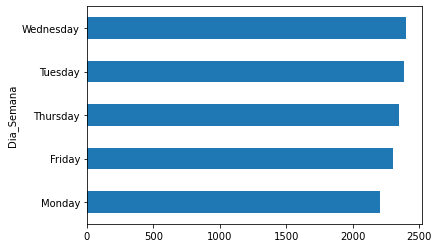

In [8]:
df_price.groupby('Dia_Semana').size().sort_values(ascending=True).plot(kind='barh')

Pode-se verificar pelo gráfico que existem dados faltantes no dataset, principalmente nas datas que correspondem aos finais de semana e feriados, vale lembrar que a cada ano os feriados mudam de dia da semana e com isso cada ano poderá ter um número de dias diferente de operação.

Como esses dados são de grande valia para o nosso experimento, foram realizados os tratamentos a seguir para amenizar este problema:

In [9]:
#Verificação do tamanho do range existente no dataset
print('Periodo correspondente ao dataset inicial de precificação:',df_price['Data'].min(),' à ',
df_price['Data'].max())

Periodo correspondente ao dataset inicial de precificação: 01/02/1974  à  31/12/2019


In [10]:
#Convertendo a coluna de tipo object para o tipo date time
formata_data(df_price,'datetime')

#Selecionando o dataset em um intervalo de 10 anos para seguir o padrão dos dados metereológicos
df_price = df_price.loc[(df_price['Data'] >= '2003-01-01') & (df_price['Data'] <= '2013-01-01')]

#Ordenando o dataset e resetando o index
df_price = df_price.sort_values(by='Data')
df_price = df_price.reset_index(drop=True)

# Adequação do formato de data
formata_data(df_price,'date')

Adequação das datas para o formato dd/mm/aaaa


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


FEITO !


In [11]:
#Completando o dataset com as datas faltantes 
date = datetime.strptime("01/01/2003", "%d/%m/%Y")
date_f = datetime.strptime("01/01/2013", "%d/%m/%Y")
df_price_all_days = fill_days(df_price, date, date_f, "Data")

#Atualizando a coluna de Dia_Semana
include_dayofweek(df_price_all_days)
df_price_all_days.head()

Feito !!!


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Adicionada a coluna de dia da semana !


Data   Valor Dia_Semana
0  01/01/2003     NaN  Wednesday
1  02/01/2003  0.6165   Thursday
2  03/01/2003  0.6125     Friday
3  04/01/2003     NaN   Saturday
4  05/01/2003     NaN     Sunday

In [12]:
print('Percentual de crescimento do dataset: {0:4.2f}%'.format((df_price_all_days['Data'].count()/df_price['Data'].count() -1)*100 ))

Percentual de crescimento do dataset: 45.69%


In [13]:
df_price_all_days['Dia_Semana'].value_counts()

Monday       522
Friday       522
Wednesday    522
Sunday       522
Thursday     522
Tuesday      522
Saturday     522
Name: Dia_Semana, dtype: int64

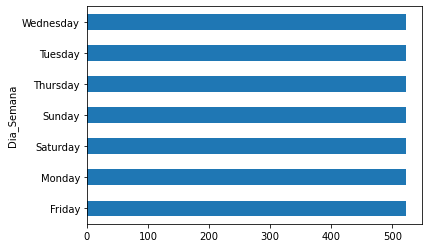

In [14]:
df_price_all_days.groupby('Dia_Semana').size().sort_values(ascending=True).plot(kind='barh')

Após analisar a base de precificação pode-se notar a falta de dados na coluna de valor devido a bolsa de valores não operar nesse periodo ou por uma falha do próprio dataset, para tratativa desse caso adotamos a estratégia de completar esses dados com a média calculada de 7 em 7 dias da coluna de Valor.

In [15]:
df_price_all_days.head()

Data   Valor Dia_Semana
0  01/01/2003     NaN  Wednesday
1  02/01/2003  0.6165   Thursday
2  03/01/2003  0.6125     Friday
3  04/01/2003     NaN   Saturday
4  05/01/2003     NaN     Sunday

In [16]:
#Convertendo a coluna de tipo object para o tipo date time
formata_data(df_price_all_days,'datetime')

#Criando o dataset com as medias calculadas
df_media7D = pd.DataFrame(df_price_all_days.set_index('Data').resample('7D').mean())

#Loop para verificar se o campo valor esta vazio, se estiver verifica qual a media mais proxima da data,
# senão encontrar ele adiciona a media do conjunto
for i, row in df_price_all_days.iterrows():
    v = row['Valor']
    if math.isnan(v):
        idx = df_media7D.iloc[(df_media7D.index <= row['Data'])]
        if idx.empty:
            df_price_all_days['Valor'][i] = df_price_all_days['Valor'].mean()
        else:
            idx = idx.sort_index(ascending=False)
            df_price_all_days['Valor'][i] = idx['Valor'][0]     
    else:
        row['Valor'] = v

print('FEITO !')
# Adequação do formato de data
formata_data(df_price_all_days,'date')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


FEITO !
Adequação das datas para o formato dd/mm/aaaa


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


FEITO !


In [17]:
df_price_all_days.head()

Data     Valor Dia_Semana
0  01/01/2003  0.624125  Wednesday
1  02/01/2003  0.616500   Thursday
2  03/01/2003  0.612500     Friday
3  04/01/2003  0.624125   Saturday
4  05/01/2003  0.624125     Sunday

Como o nosso experimento visa prever alta ou baixa de preço de acordo com a variação dos dados metereológicos adicionamos uma nova coluna ao dataset de precificação e classificamos os dados de acordo com os critérios abaixo:

Alta : Preço do dia anterior menor ou  igual ao preço atual.

Baixa : Preço do dia anterior maior que o preço atual.

In [18]:
v0 = 0
status_lst = []
previous = 'Alta'
for i, row in df_price_all_days.iterrows():
    sample = row['Valor'] - v0
    if sample>0:
        result = 'Alta'
    elif sample == 0:
        result == previous
    else:
        result = 'Baixa'
        
    v0 = row['Valor']
    previous = result
    status_lst.append(result)
    
df_price_all_days['Status'] = status_lst

#fixed_price.to_csv('price_full.csv', index=False)
df_price_all_days.head()

Data     Valor Dia_Semana Status
0  01/01/2003  0.624125  Wednesday   Alta
1  02/01/2003  0.616500   Thursday  Baixa
2  03/01/2003  0.612500     Friday  Baixa
3  04/01/2003  0.624125   Saturday   Alta
4  05/01/2003  0.624125     Sunday   Alta

**Explorando a base de dados metereológicos**

Os dados meteorológicos vieram inicialmente em um arquivo de texto com um cabeçalho que precisou ser removido, outro tratamento é a junção dos dados dentro de um dia, todas as estações faziam as medições em dois momentos dos dias e portanto cada dia era representado por duas linhas cada uma com informações parciais que foram unidas e uma única linha. para cada dia.

**As estações coletadas foram:**

1. - SOROCABA - SP
2. - SAO PAULO MIR de SANTANA  - SP
3. - URUSSANGA - SC
4. - BAGE - RS
5. - SANTANA DO LIVRAMENTO - RS
6. - ENCRUZILHADA DO SUL - RS
7. - SANTA MARIA - RS
8. - CAXIAS DO SUL - RS
9. - CRUZ ALTA - RS
10. - PASSO FUNDO - RS
11. - BOM JESUS - RS
12. - URUSSANGA - SC
13. - CAMPOS NOVOS - SC
14. - CHAPECO - SC
15. - INDAIAL - SC
16. - CURITIBA - PR
17. - IRATI - PR
18. - CAMPO MOURAO - PR
19. - LONDRINA - PR
20. - TAUBATE - SP
21. - RESENDE - RJ
22. - RIO DE JANEIRO - RJ
23. - LAMBARI - MG
24. - CALDAS P  DE CALDAS  - MG
25. - SAO CARLOS - SP
26. - CATANDUVA - SP
27. - AVARE - SP
28. - PONTA PORA - MS
29. - IVINHEMA - MS
30. - PARANAIBA - MS
31. - FRUTAL - MG
32. - UBERABA - MG
33. - ARAXA - MG
34. - BAMBUI - MG
35. - BOM DESPACHO - MG
36. - FLORESTAL - MG
37. - CARATINGA - MG
38. - AIMORES - MG
39. - VITORIA - ES
40. - CORUMBA - MS
41. - NHUMIRIM  NHECOLANDIA  - MS
42. - CAPINOPOLIS - MG
43. - CATALAO - GO
44. - IPAMERI - GO
45. - RIO VERDE - GO
46. - JATAI - GO
47. - PARACATU - MG
48. - JOAO PINHEIRO - MG
49. - PIRAPORA - MG
50. - MONTES CLAROS - MG
51. - CARBONITA - MG
52. - ARACUAI - MG
53. - PEDRA AZUL - MG
54. - GUARATINGA - BA
55. - CARAVELAS - BA
56. - SAO MATEUS - ES
57. - VITORIA DA CONQUISTA - BA
58. - MONTE AZUL - MG
59. - MOCAMBINHO - MG
60. - JANUARIA - MG
61. - ARINOS - MG
62. - RONCADOR - DF
63. - PIRENOPOLIS - GO
64. - GOIANIA - GO
65. - GOIAS - GO
66. - ARAGARCAS - GO
67. - POXOREO - MT
68. - PADRE RICARDO REMETTER - MT
69. - CACERES - MT
70. - DIAMANTINO - MT
71. - NOVA XAV  XAVANTINA  - MT
72. - POSSE - GO
73. - CORRENTINA - BA
74. - BOM JESUS DA LAPA - BA
75. - CAETITE - BA
76. - ITUACU - BA
77. - SAO JOSE DO RIO CLARO - MT
78. - CANARANA - MT
79. - CORRENTINA - BA
80. - BOM JESUS DA LAPA - BA
81. - ITIRUCU  JAGUAQUARA  - BA
82. - SALVADOR  ONDINA  - BA
83. - CRUZ DAS ALMAS - BA
84. - ITABERABA - BA
85. - LENCOIS - BA
86. - BARREIRAS - BA
87. - TAGUATINGA - TO
88. - PEIXE - TO
89. - GLEBA CELESTE - MT
90. - PALMAS - TO
91. - STa  R  DE CASSIA  IBIPETUBA  - BA
92. - BARRA - BA
93. - IRECE - BA
94. - JACOBINA - BA
95. - MONTE SANTO - BA
96. - CIPO - BA
97. - ARACAJU - SE
98. - MACEIO - AL
99. - RECIFE  CURADO  - PE
100. - PALMEIRA DOS INDIOS - AL
101. - PAULO AFONSO - BA
102. - CABROBO - PE
103. - PAULISTANA - PI
104. - BOM JESUS DO PIAUI - PI
105. - ALTO PARNAIBA - MA
106. - PEDRO AFONSO - TO
107. - PALMAS - TO
108. - MATUPA - MT
109. - RIO BRANCO - AC
110. - TARAUACA - AC
111. - CRUZEIRO DO SUL - AC
112. - LABREA - AM
113. - SAO FELIX DO XINGU - PA
114. - ARAGUAINA - TO
115. - CAROLINA - MA
116. - BALSAS - MA
117. - SAO JOAO DO PIAUI - PI
118. - CABROBO - PE
119. - TRIUNFO - PE
120. - MONTEIRO - PB
121. - ARCOVERDE - PE
122. - SURUBIM - PE
123. - JOAO PESSOA - PB
124. - CAMPINA GRANDE - PB
125. - PATOS - PB
126. - IGUATU - CE
127. - TAUA - CE
128. - CRATEUS - CE
129. - TERESINA - PI
130. - TAUA - CE
131. - SERIDO  CAICO  - RN
132. - NATAL - RN
133. - MACAU - RN
134. - JAGUARUANA - CE
135. - FORTALEZA - CE
136. - GUARAMIRANGA - CE
137. - SOBRAL - CE
138. - PARNAIBA - PI
139. - CHAPADINHA - MA
140. - SAO LUIS - MA
141. - ZE DOCA - MA
142. - TRACUATEUA - PA
143. - BELEM - PA
144. - CAMETA - PA
145. - CAMETA - PA
146. - MONTE ALEGRE - PA
147. - PARINTINS - AM
148. - MANAUS - AM
149. - TEFE - AM
150. - BARCELOS - AM


In [19]:
print("Inicio")

#filename = 'station'+str(basei)+'.csv'       
weather_full_df = pd.DataFrame([])
#stations = full_df['Estacao'].unique()

for i in range(150):
    if i>0 :
        filename = '../input/brazilian-weather-stations/station'+str(i)+'.csv'
        print("Processando "+filename)
        df = pd.read_csv(filename, sep=';')
        weather_full_df['Precipitacao'+str(i)] = df['Precipitacao']
        weather_full_df['TempMaxima'+str(i)] = df['TempMaxima']
        weather_full_df['TempMinima'+str(i)] = df['TempMinima']
        weather_full_df['Insolacao'+str(i)] = df['Insolacao']
        weather_full_df['Evaporacao Piche'+str(i)] = df['Evaporacao Piche']
        weather_full_df['Temp Comp Media'+str(i)] = df['Temp Comp Media']
        weather_full_df['Umidade Relativa Media'+str(i)] = df['Umidade Relativa Media']
        weather_full_df['Velocidade do Vento Media'+str(i)] = df['Velocidade do Vento Media']

print(weather_full_df.shape)

Inicio
Processando ../input/brazilian-weather-stations/station1.csv
Processando ../input/brazilian-weather-stations/station2.csv
Processando ../input/brazilian-weather-stations/station3.csv
Processando ../input/brazilian-weather-stations/station4.csv
Processando ../input/brazilian-weather-stations/station5.csv
Processando ../input/brazilian-weather-stations/station6.csv
Processando ../input/brazilian-weather-stations/station7.csv
Processando ../input/brazilian-weather-stations/station8.csv
Processando ../input/brazilian-weather-stations/station9.csv
Processando ../input/brazilian-weather-stations/station10.csv
Processando ../input/brazilian-weather-stations/station11.csv
Processando ../input/brazilian-weather-stations/station12.csv
Processando ../input/brazilian-weather-stations/station13.csv
Processando ../input/brazilian-weather-stations/station14.csv
Processando ../input/brazilian-weather-stations/station15.csv
Processando ../input/brazilian-weather-stations/station16.csv
Processand

In [20]:
weather_full_df.head()

Precipitacao1  TempMaxima1  TempMinima1  Insolacao1  Evaporacao Piche1  \
0            NaN         30.0         14.1         NaN                NaN   
1            6.7         29.6         14.0         NaN                NaN   
2           28.7         31.1         13.9         NaN                NaN   
3            0.0         30.8         14.6         NaN                NaN   
4            0.0         29.3         13.7         NaN                NaN   

   Temp Comp Media1  Umidade Relativa Media1  Velocidade do Vento Media1  \
0             23.12                    79.50                    1.333333   
1             22.42                    81.00                    1.333333   
2             22.82                    84.25                    1.000000   
3             23.48                    79.50                    1.000000   
4             22.86                    79.25                    1.000000   

   Precipitacao2  TempMaxima2  ...  Umidade Relativa Media148  \
0            NaN          NaN  ...                      88.50   
1            NaN          NaN  ...                        NaN   
2            NaN          NaN  ...                      93.25   
3            NaN          NaN  ...                        NaN   
4            NaN          NaN  ...                      87.25   

   Velocidade do Vento Media148  Precipitacao149  TempMaxima149  \
0                      0.666667              NaN           28.8   
1                           NaN              NaN            NaN   
2                      2.333333              NaN           28.8   
3                           NaN              0.0            NaN   
4                      2.333333              NaN           30.0   

   TempMinima149  Insolacao149  Evaporacao Piche149  Temp Comp Media149  \
0            NaN           7.2                  1.9               26.68   
1           24.2           NaN                  NaN                 NaN   
2            NaN           7.5                  2.2               27.10   
3           24.9           NaN                  NaN                 NaN   
4            NaN          10.4                  0.8               27.42   

   Umidade Relativa Media149  Velocidade do Vento Media149  
0                      86.75                           NaN  
1                        NaN                           NaN  
2                      86.50                           NaN  
3                        NaN                           NaN  
4                      81.75                           NaN  

[5 rows x 1192 columns]

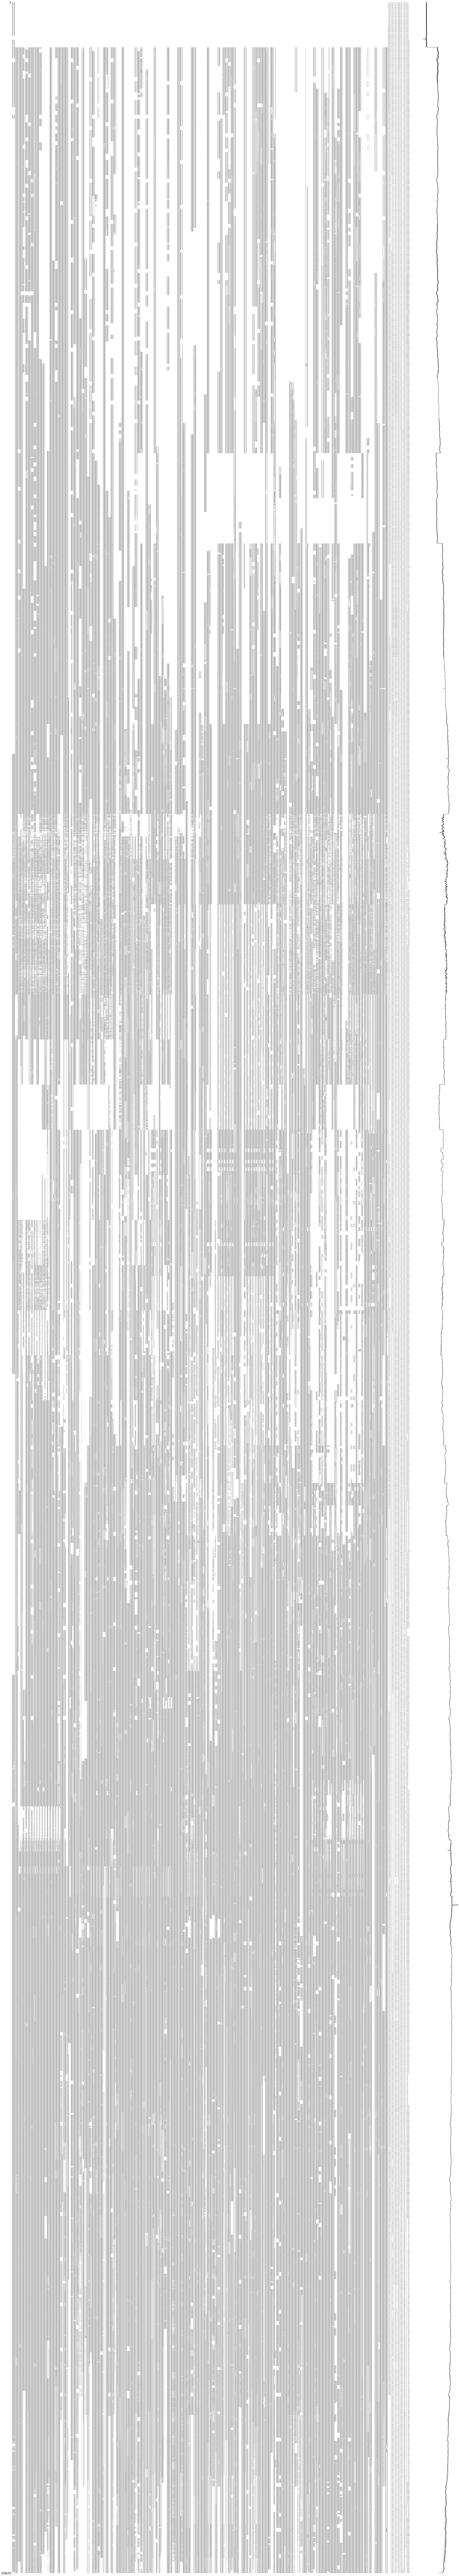

In [21]:
msno.matrix(weather_full_df, figsize=(50, 300))

In [22]:
weather_full_df.shape

(20820, 1192)

In [23]:
#sns.heatmap(weather_full_df.isnull(), cbar=False)

Ao tentar realizar a identificação dos dados faltantes, para poder ilustrar de maneira mais intuitiva, foram realizados inúmeras maneiras para ter uma melhor compreensão de quais estações deveríamos descartar devido a falta de valores em certos períodos que poderia comprometer com o aprendizado do modelo.

In [24]:
#gerando uma tabela para identificar quais estações possuíam os dados faltantes e a porcentagem de dados faltantes em cada dataset
df2 = pd.DataFrame()
station = []

for i in range(1,151):
    df = pd.read_csv('../input/brazilian-weather-stations/station'+ str(i) + '.csv', sep=';', index_col=0)
    
    # Checando quais variaveis estão com valores faltantes
    missing_values = list(df.columns[df.isnull().any()])
    df[missing_values].isnull().sum()
    labels = [] 
    valuecount = [] 
    percentcount = [] 
    station.append('estacao '+str(i))
    
    if len(missing_values) == 9:
        
        #removendo a coluna 'Hora'
        del missing_values[1]
        
        for col in missing_values:
            labels.append(col)
            valuecount.append(df[col].isnull().sum())
            # df.shape[0] dará a contagem total de linhas
            percentcount.append(df[col].isnull().sum()/df.shape[0])
        df2 = df2.append([percentcount])
        
    else:
        
        for col in missing_values:
            labels.append(col)
            valuecount.append(df[col].isnull().sum())
            # df.shape[0] dará a contagem total de linhas
            percentcount.append(df[col].isnull().sum()/df.shape[0])    
        df2 = df2.append([percentcount])   

In [25]:
df2.columns = missing_values
df2.index = station
df2

Precipitacao  TempMaxima  TempMinima  Insolacao  \
estacao 1        0.381892    0.381892    0.383285   0.468780   
estacao 2        0.032133    0.047166    0.044380   0.287560   
estacao 3        0.216282    0.217819    0.230211   0.527378   
estacao 4        0.089049    0.103410    0.108261   0.092747   
estacao 5        0.449856    0.461671    0.461623   0.554995   
...                   ...         ...         ...        ...   
estacao 146      0.500973    0.490963    0.490838   0.513869   
estacao 147      0.500812    0.500344    0.543729   0.547058   
estacao 148      0.502641    0.502444    0.494165   0.505982   
estacao 149      0.506332    0.522255    0.489733   0.555515   
estacao 150      0.500224    0.511600    0.504200   0.592368   

             Evaporacao Piche  Temp Comp Media  Umidade Relativa Media  \
estacao 1            0.422190         0.387032                0.385735   
estacao 2            0.036551         0.049232                0.038761   
estacao 3            0.321230         0.328915                0.325793   
estacao 4            0.145197         0.155283                0.201441   
estacao 5            0.608309         0.530836                0.515706   
...                       ...              ...                     ...   
estacao 146          0.502228         0.502102                0.564669   
estacao 147          0.516823         0.549809                0.616028   
estacao 148          0.549539         0.514187                0.577030   
estacao 149          0.571499         0.542604                0.615517   
estacao 150          0.644879         0.538067                0.615253   

             Velocidade do Vento Media  
estacao 1                     0.439145  
estacao 2                     0.132709  
estacao 3                     0.326609  
estacao 4                     0.149760  
estacao 5                     0.512296  
...                                ...  
estacao 146                   0.504895  
estacao 147                   0.512971  
estacao 148                   0.511780  
estacao 149                   0.510328  
estacao 150                   0.519474  

[150 rows x 8 columns]

Uma das tentativas realizadas foram por meio do gráfico de calor para verificar quais eram os datasets com muitos dados faltante. O gráfico pode ser visualizado abaixo.

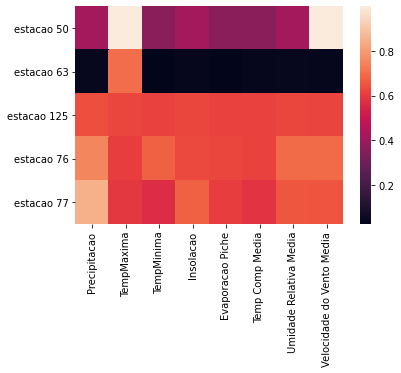

In [26]:
#Datasets com os maiores índices de valores faltantes
w_dfs = df2.sort_values('TempMaxima', axis=0, ascending=False, inplace=False).head(5)

sns.heatmap(w_dfs)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


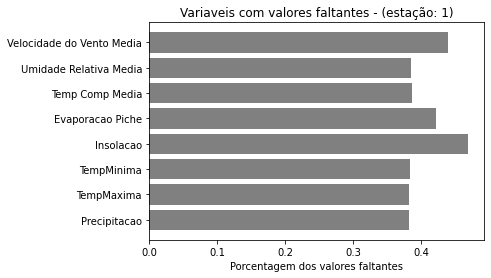

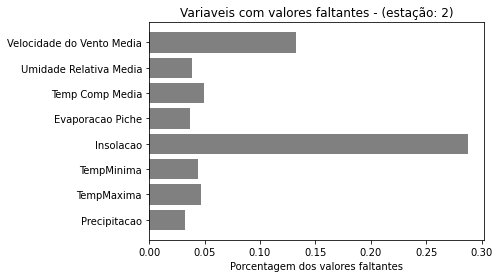

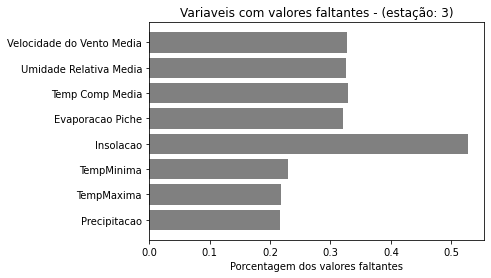

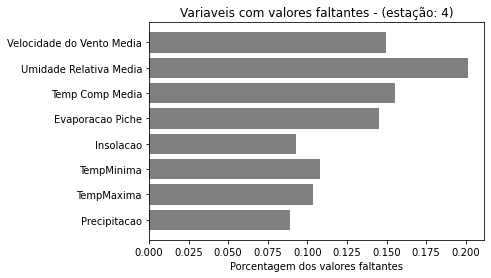

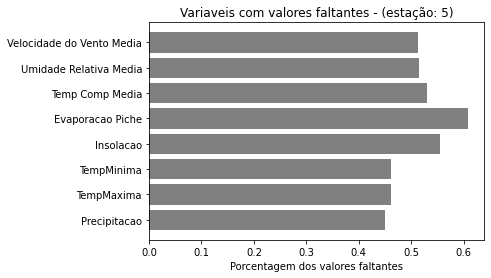

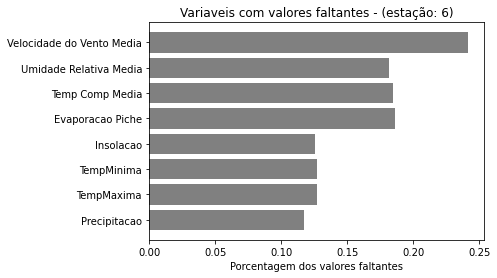

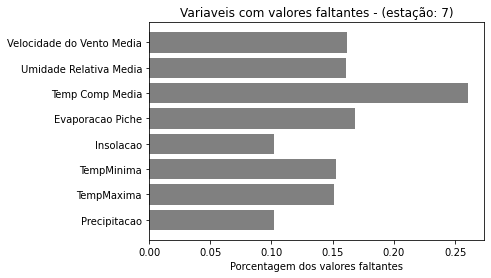

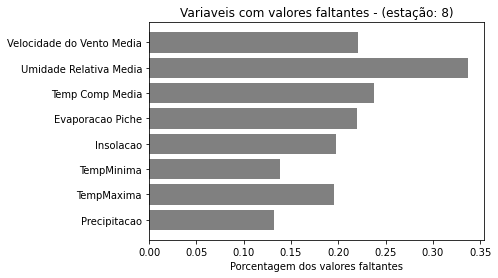

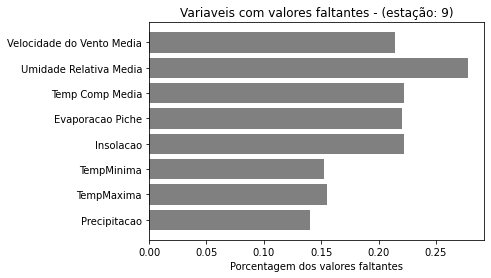

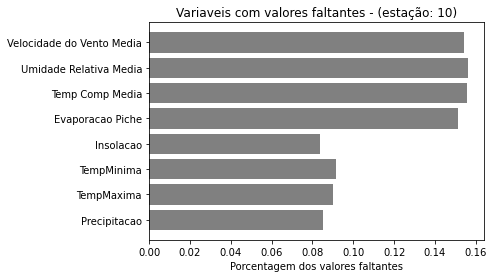

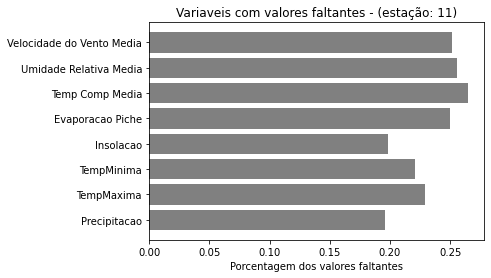

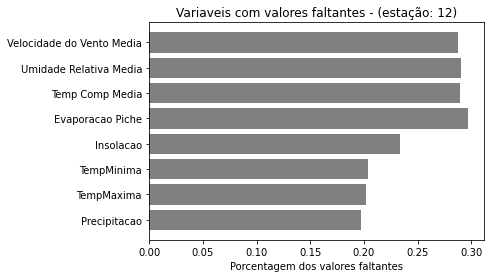

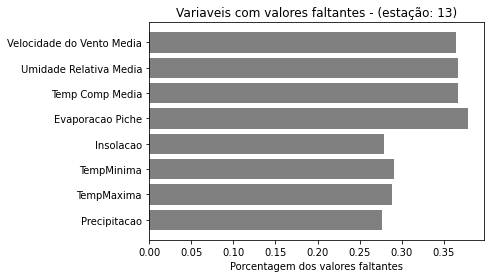

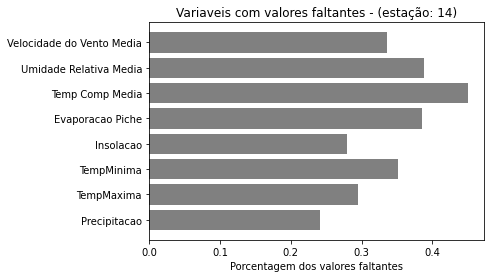

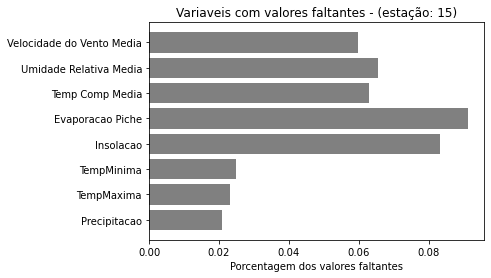

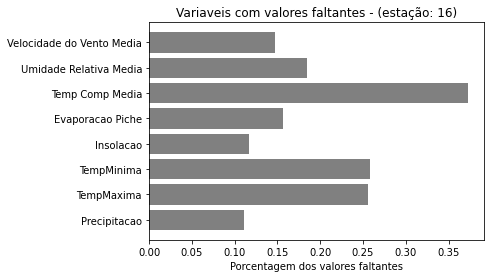

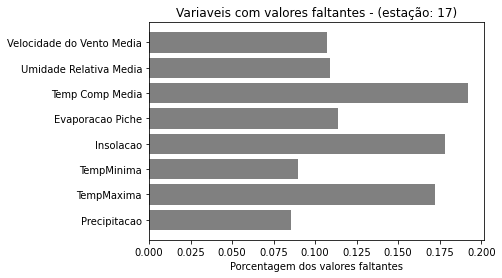

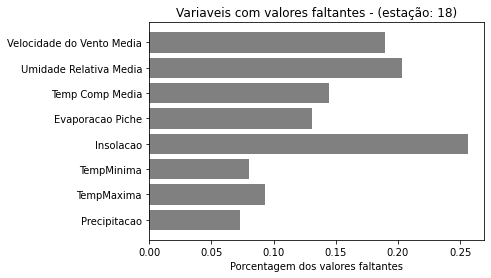

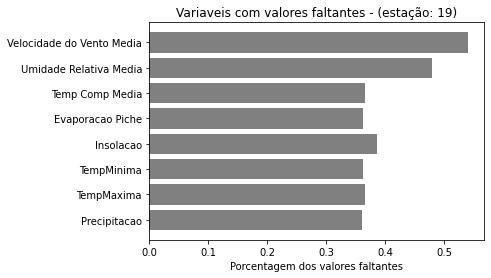

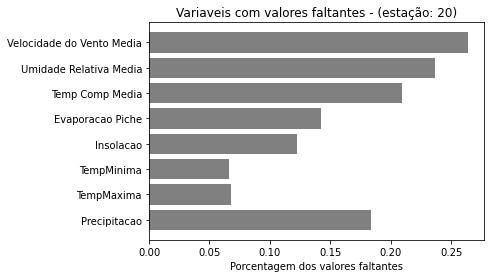

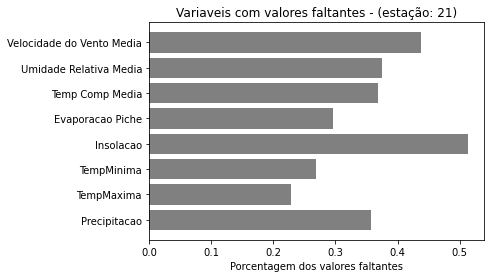

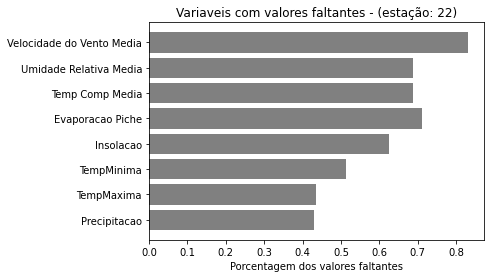

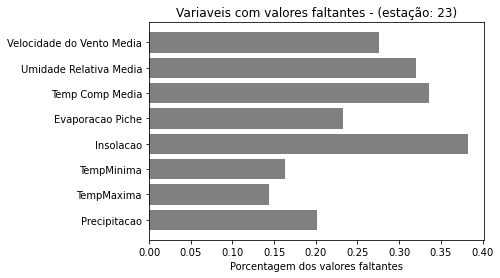

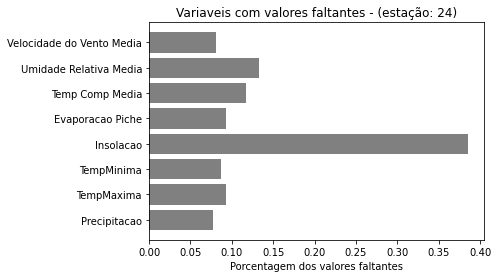

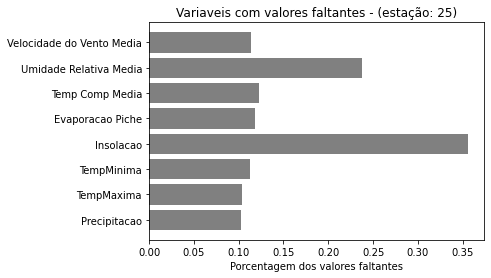

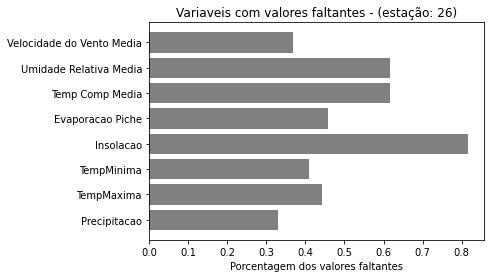

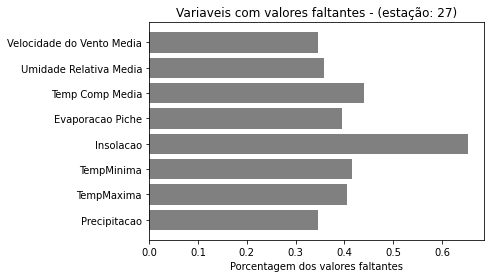

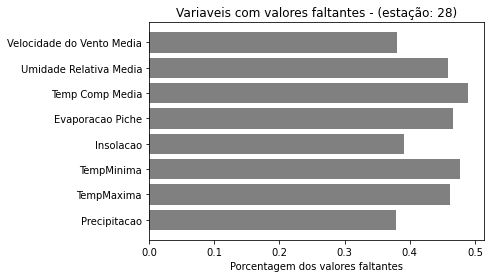

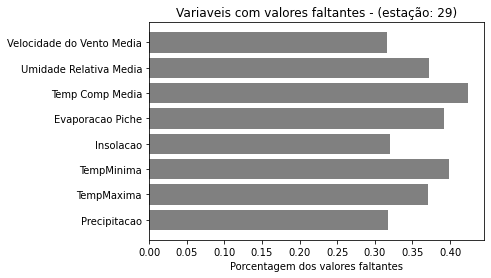

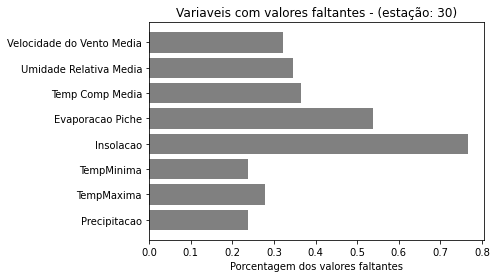

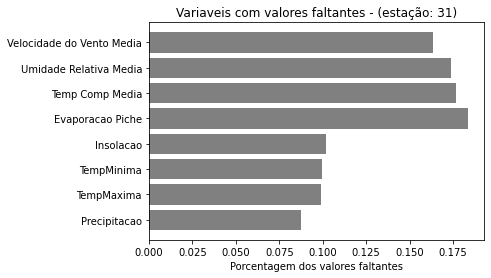

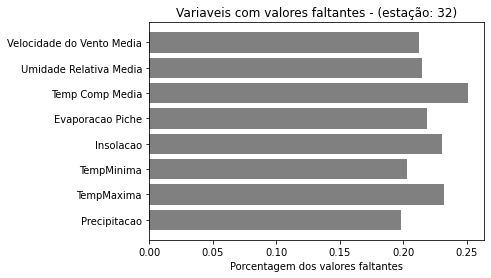

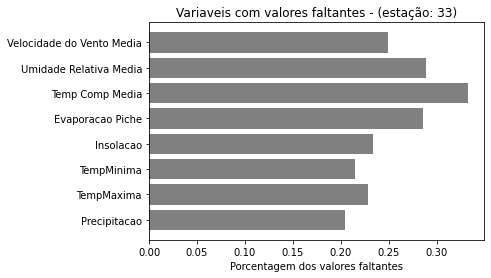

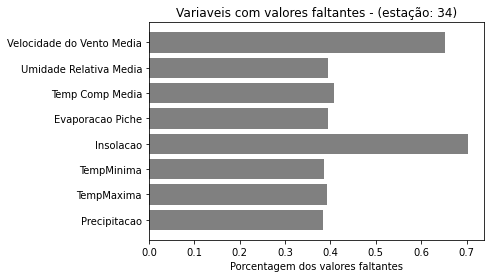

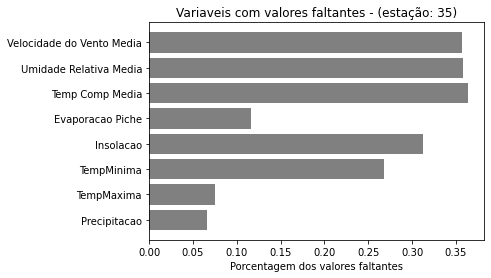

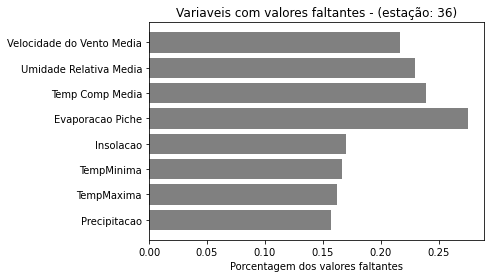

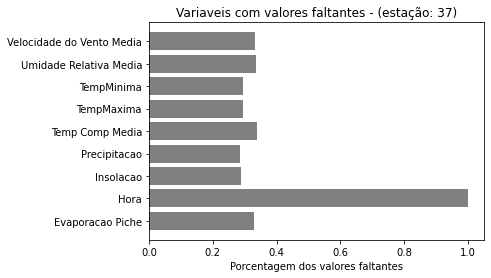

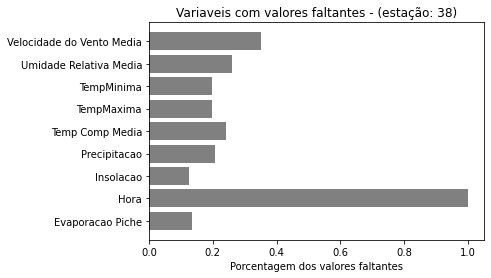

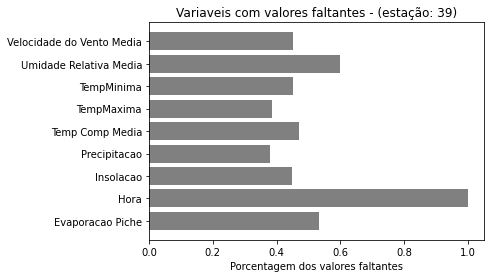

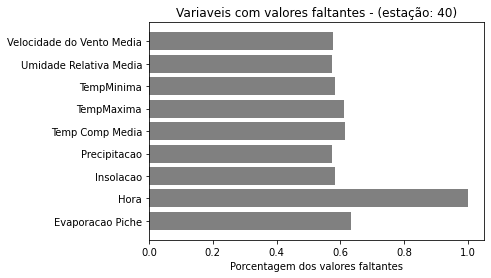

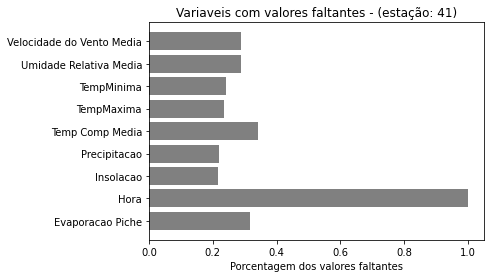

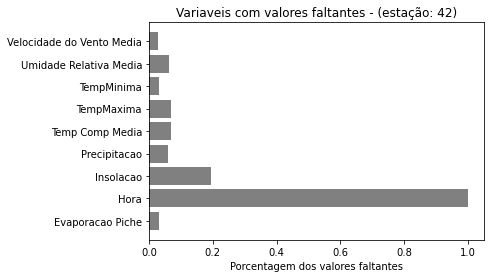

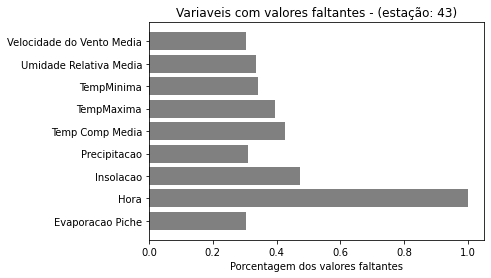

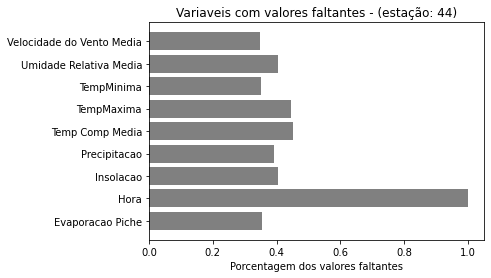

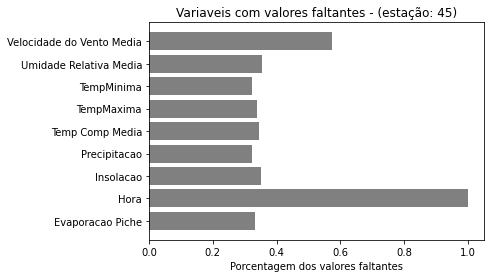

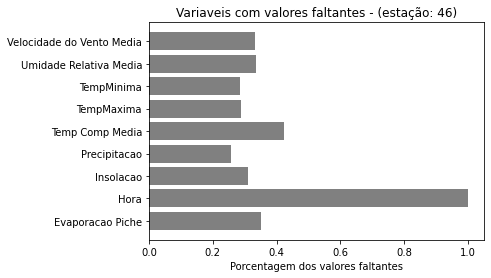

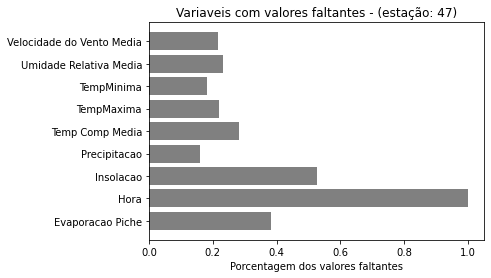

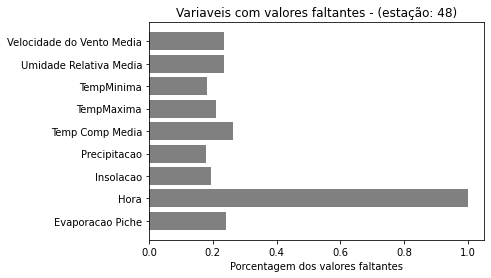

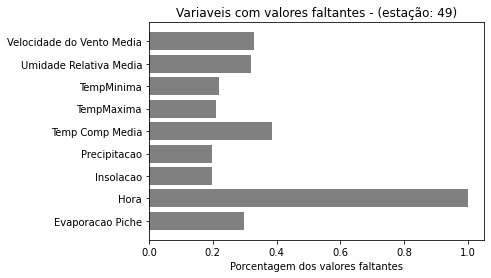

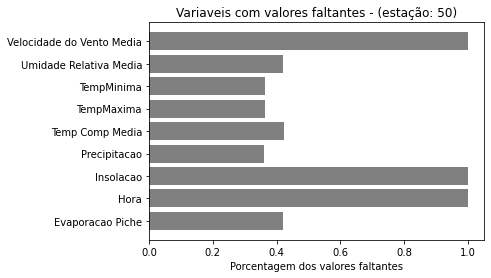

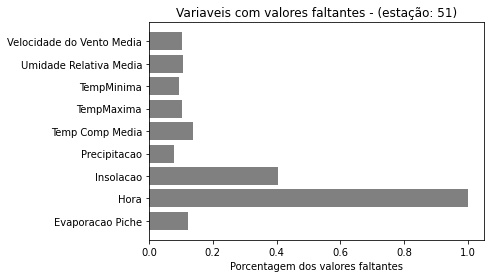

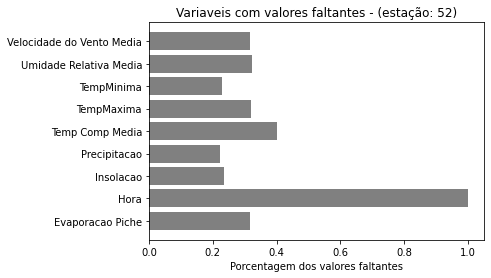

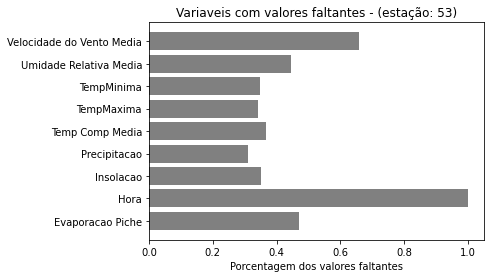

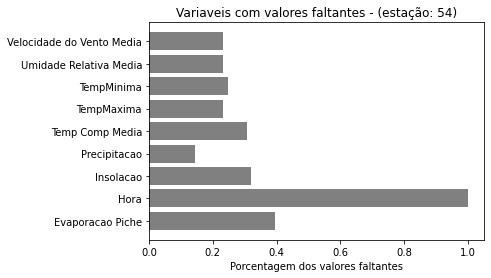

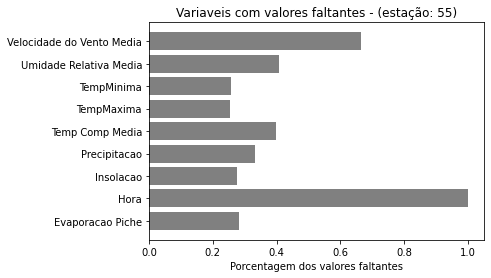

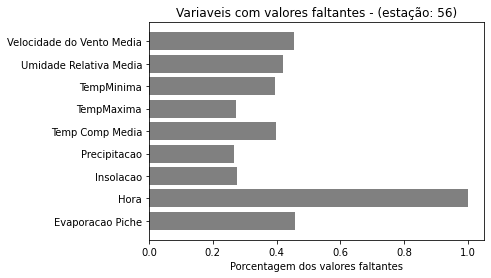

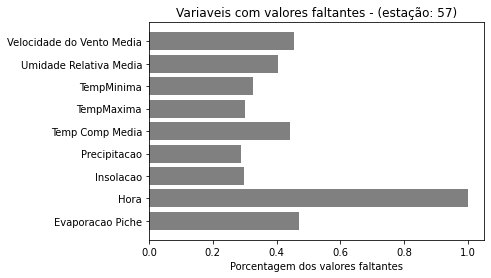

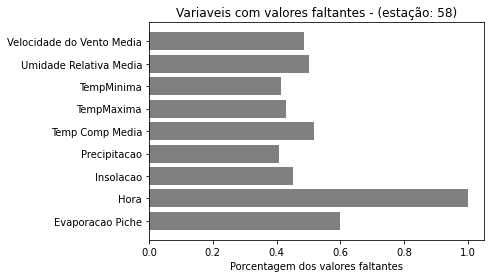

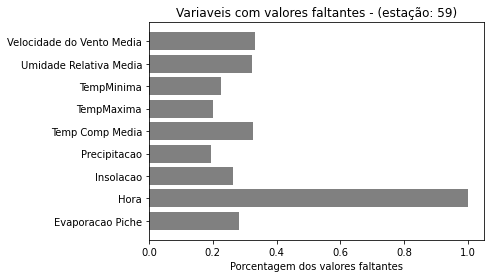

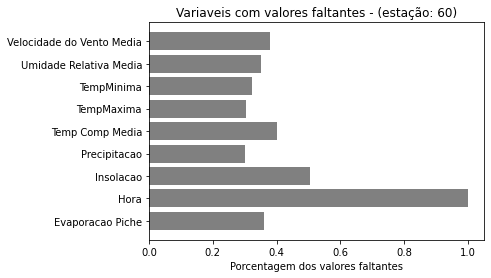

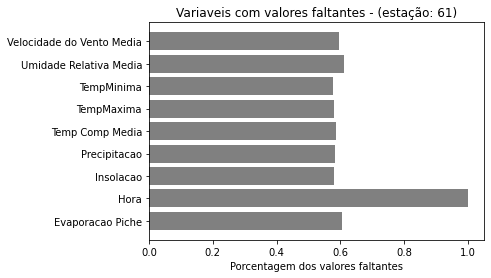

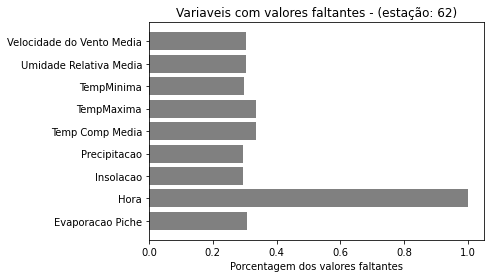

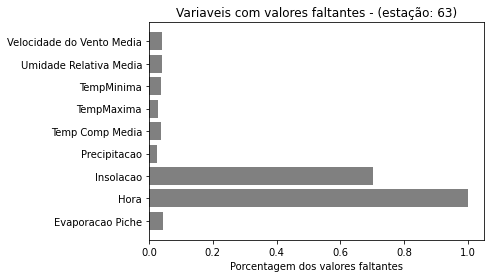

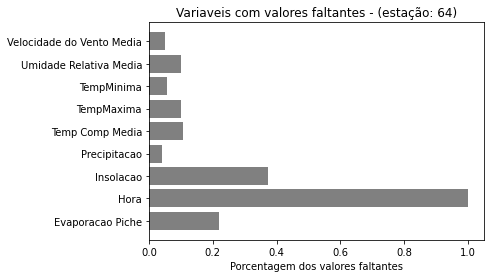

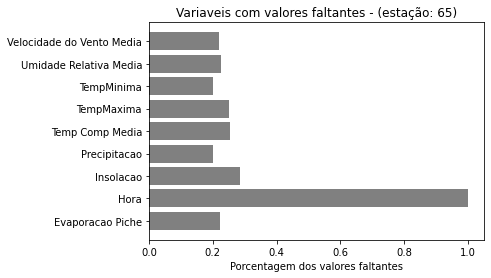

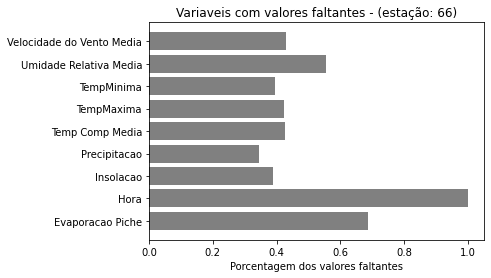

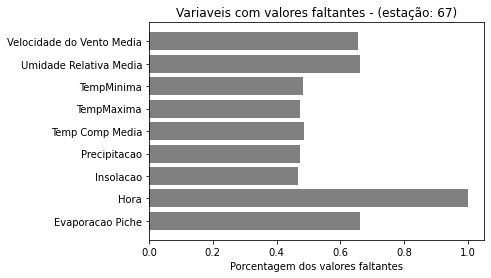

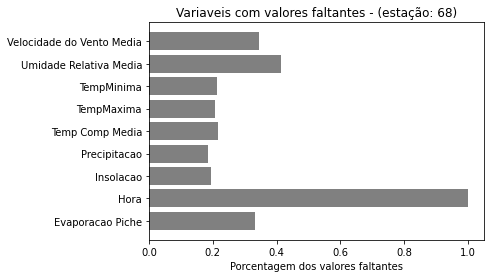

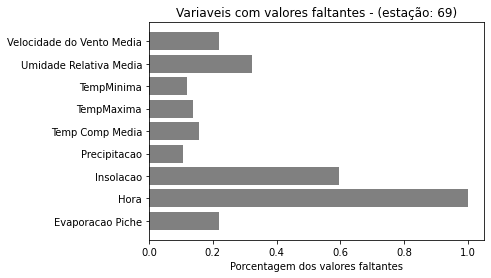

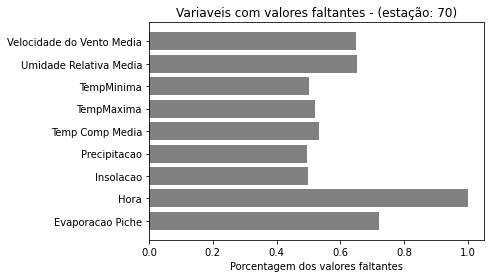

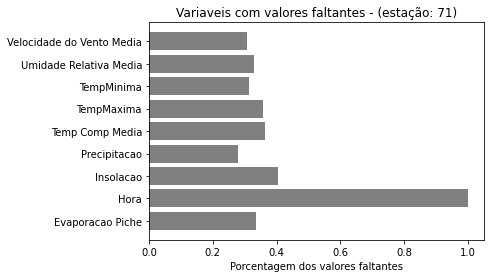

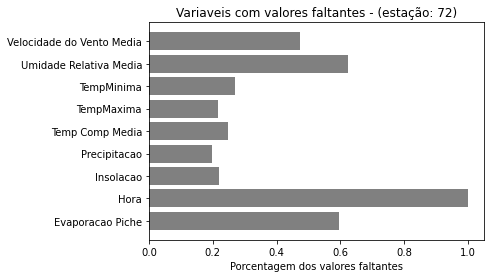

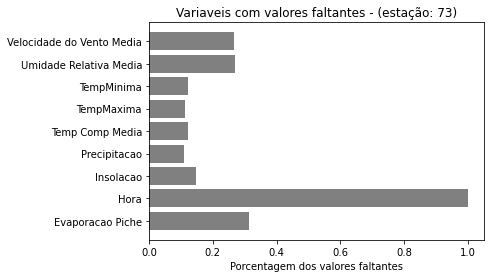

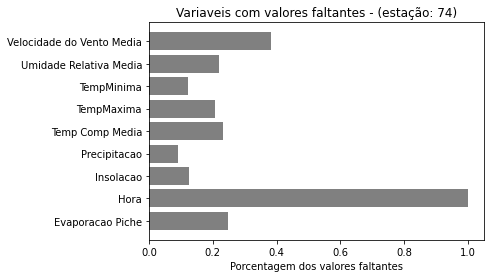

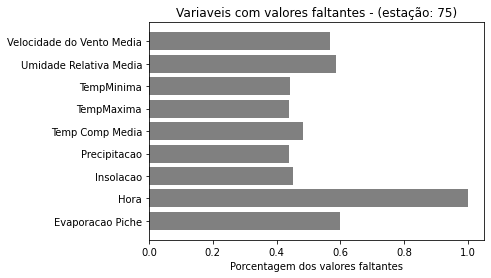

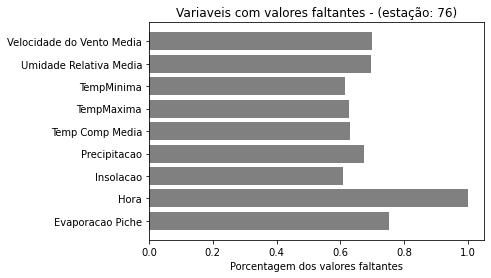

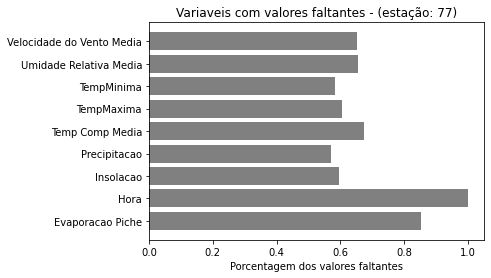

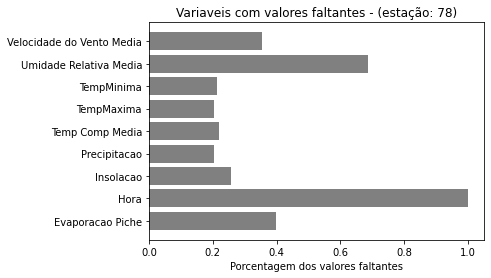

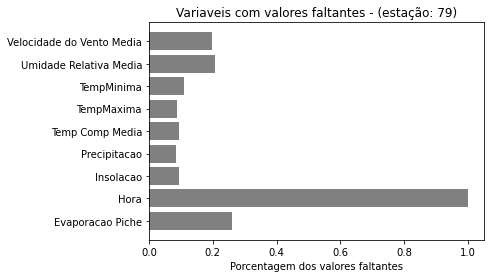

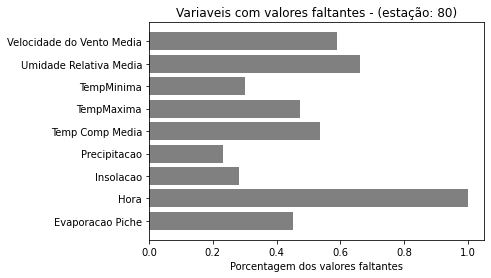

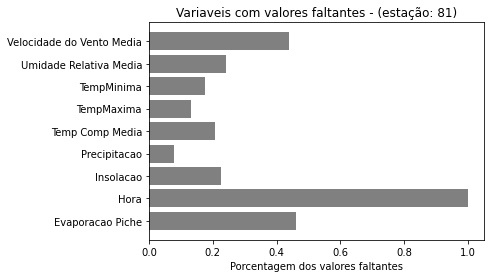

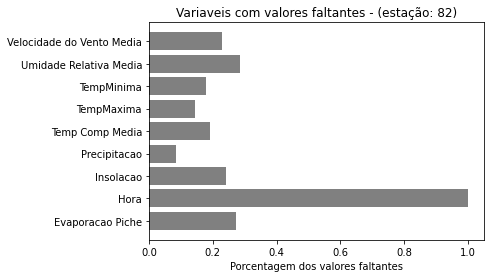

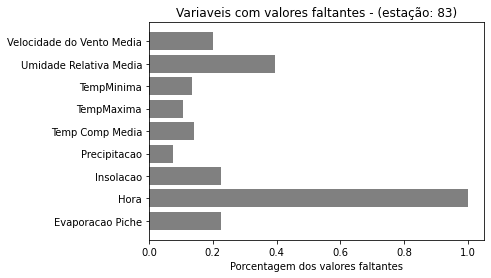

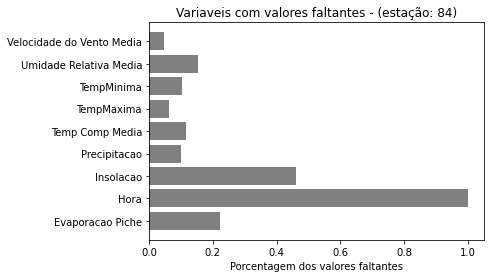

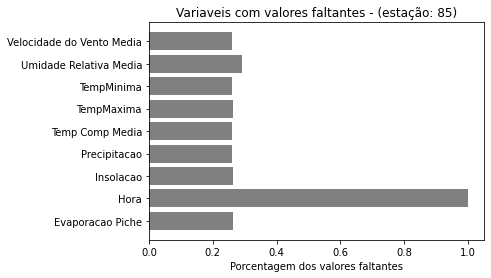

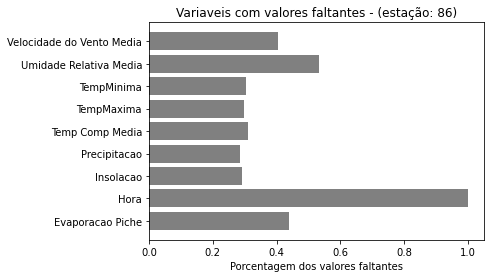

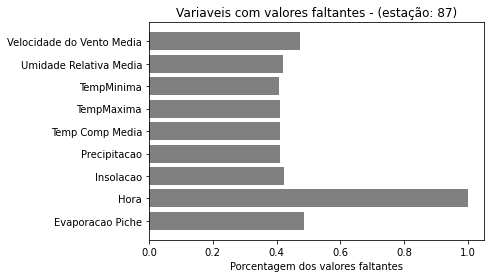

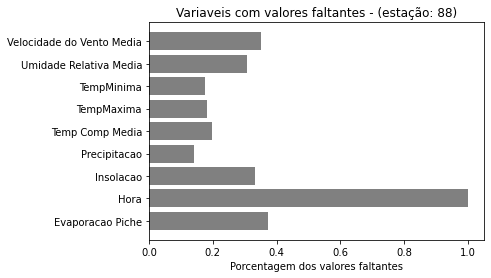

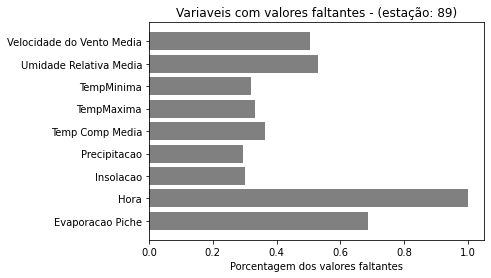

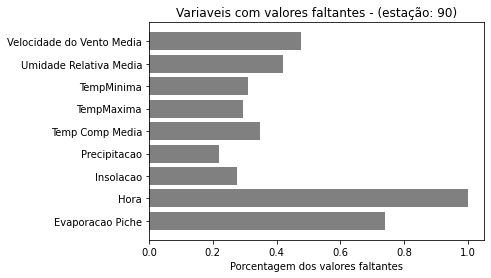

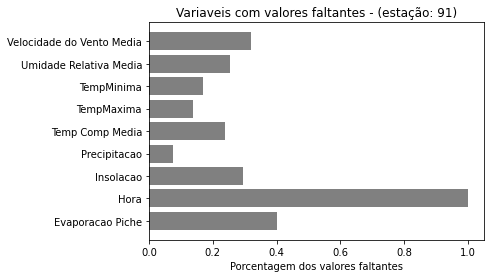

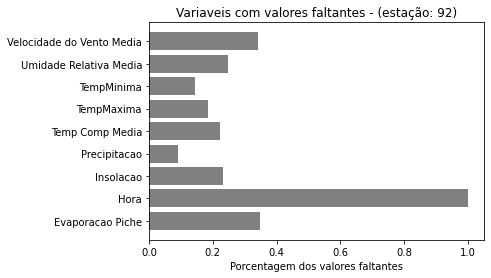

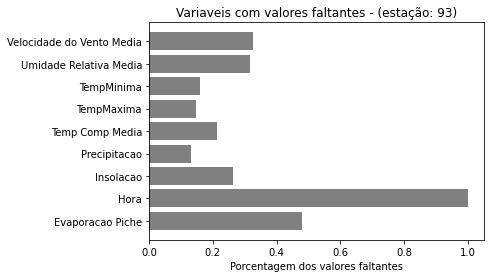

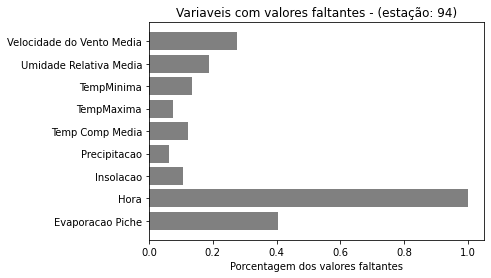

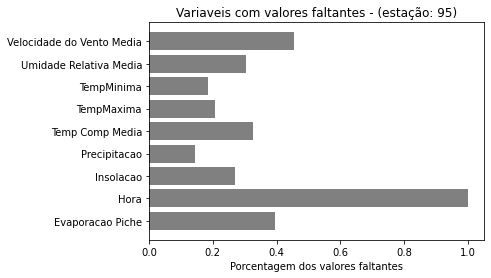

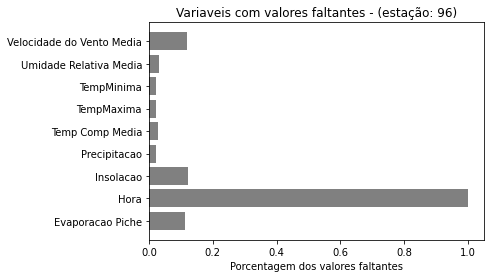

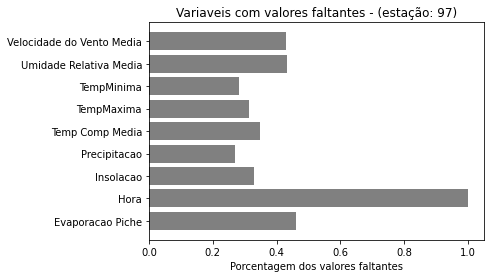

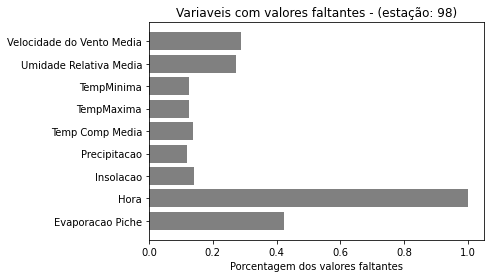

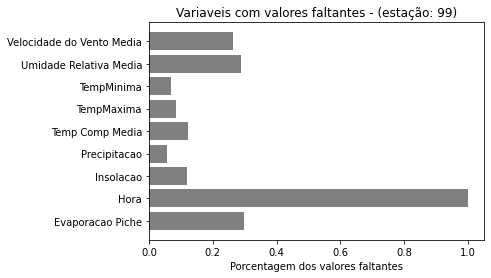

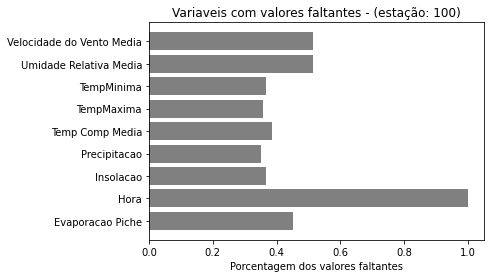

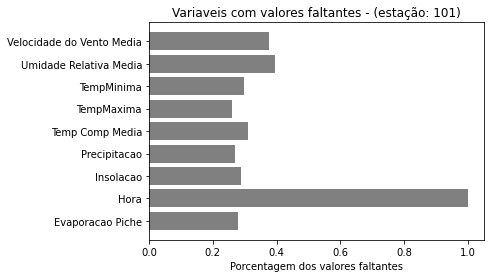

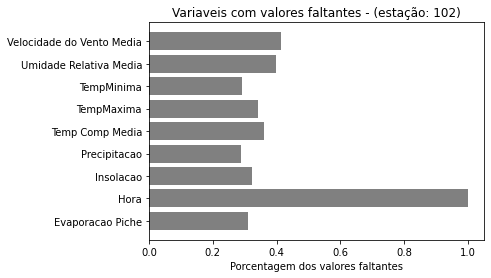

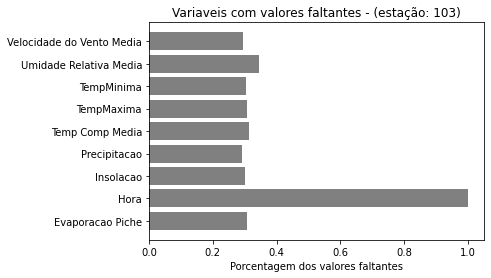

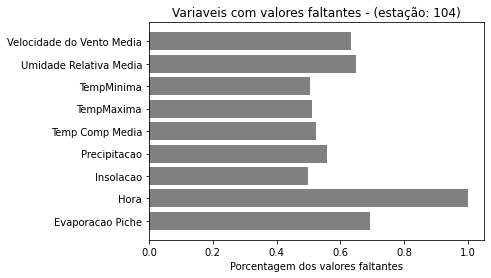

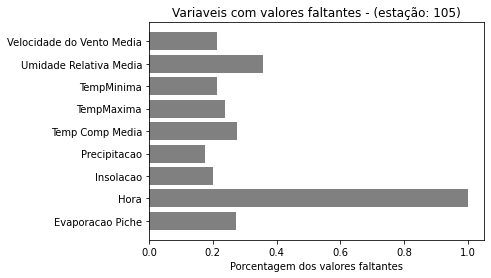

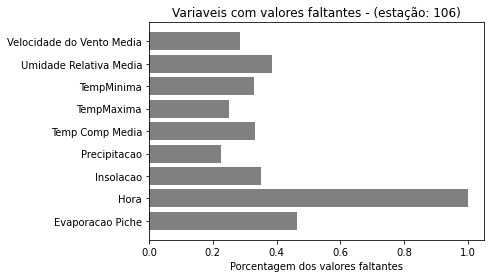

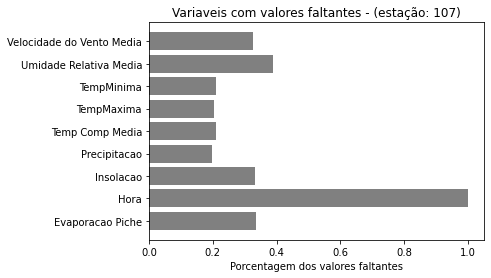

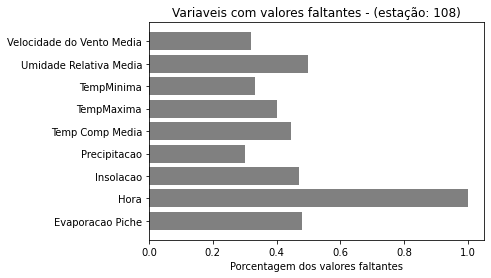

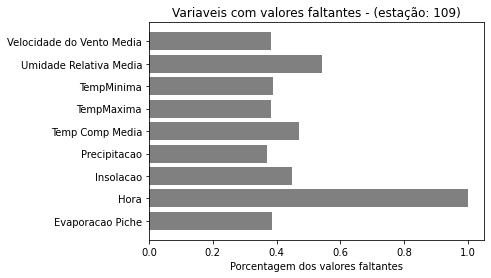

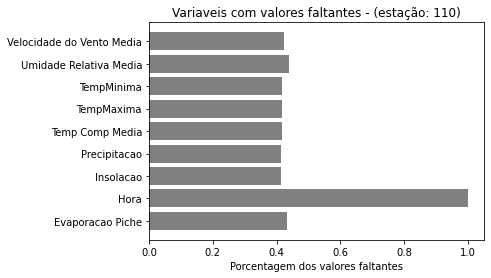

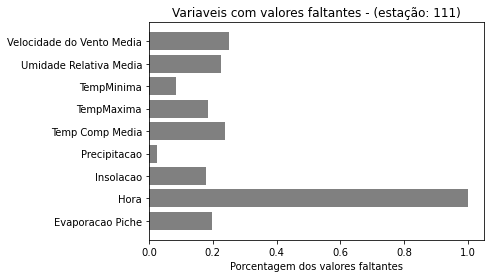

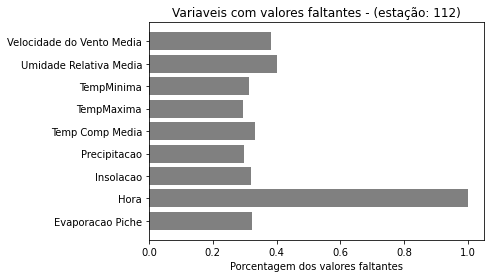

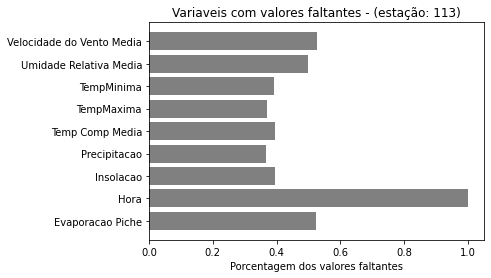

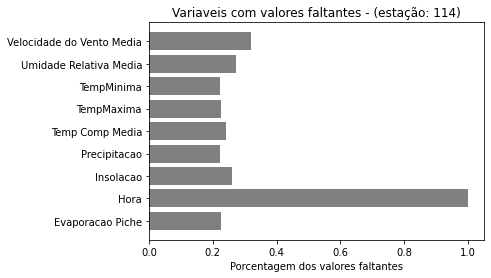

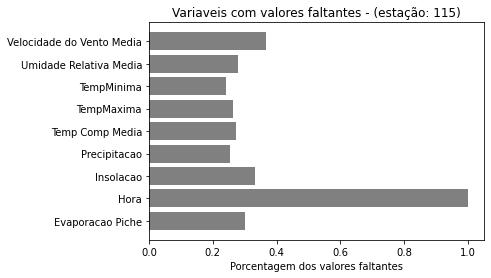

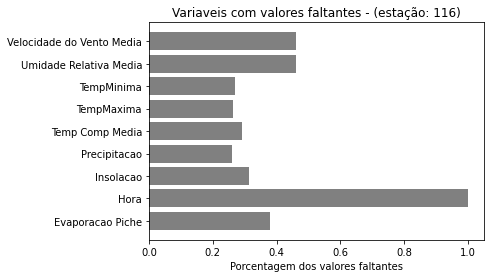

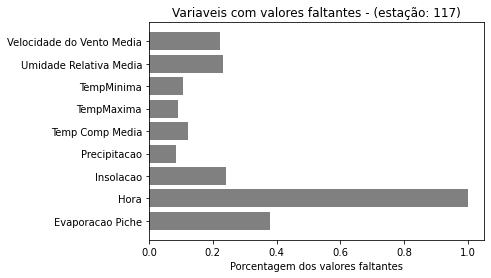

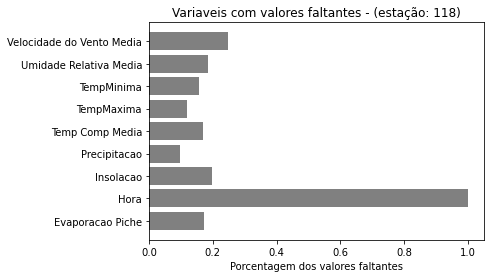

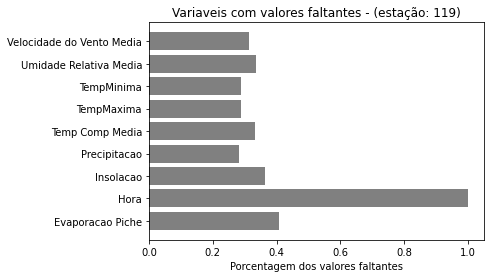

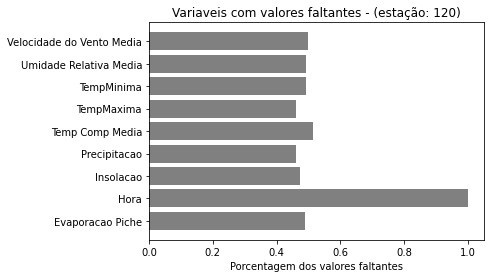

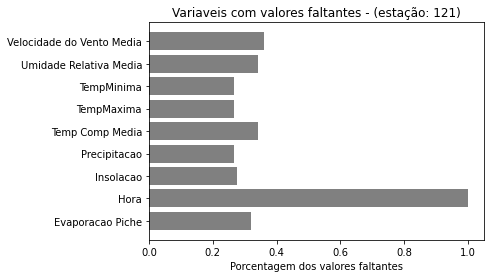

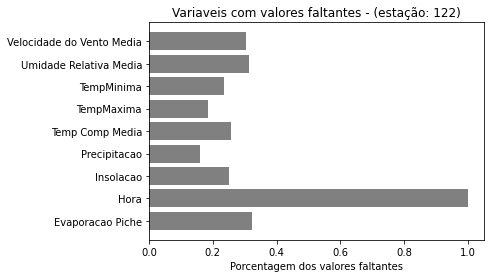

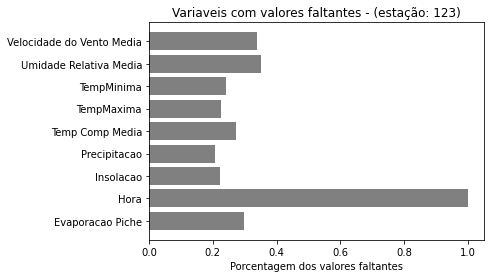

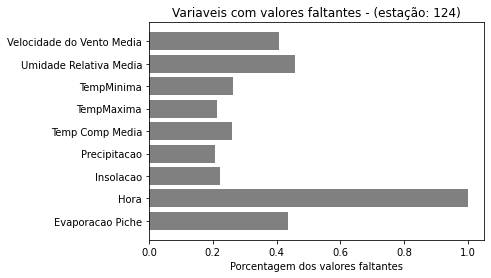

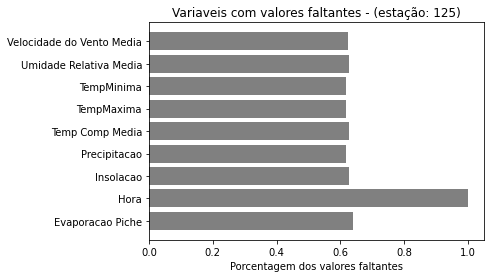

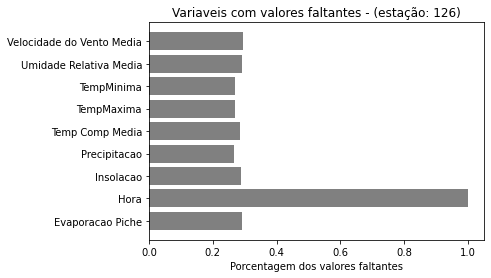

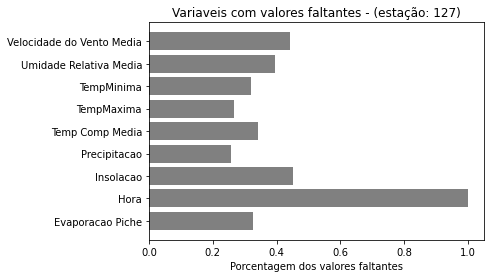

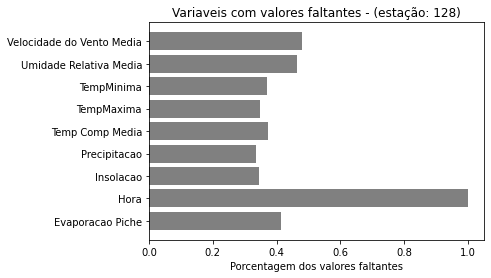

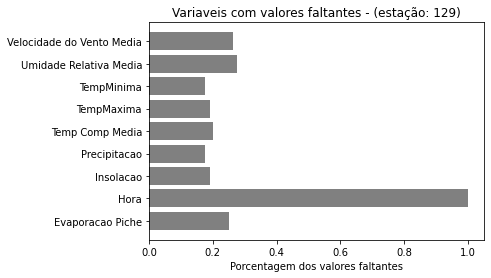

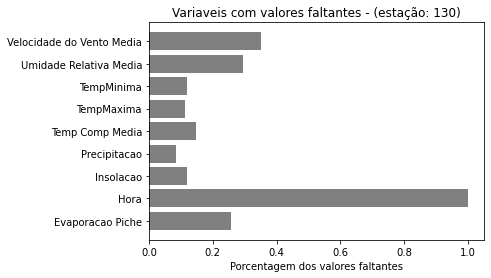

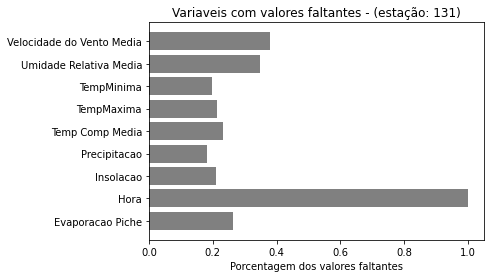

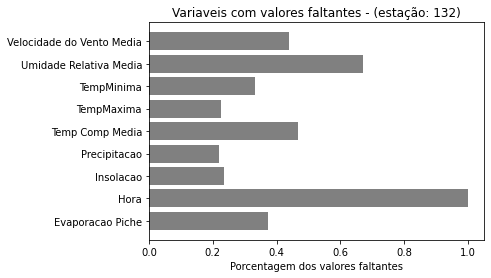

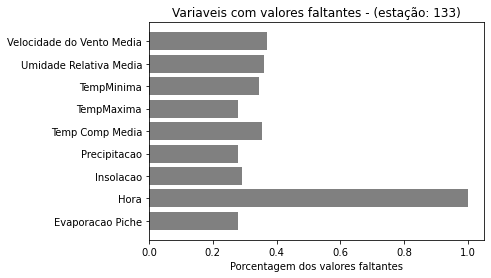

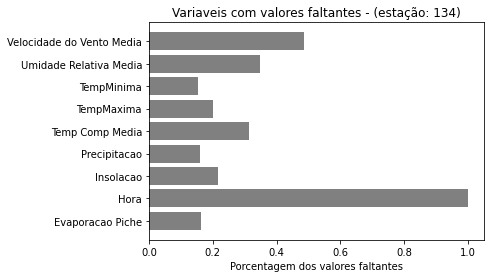

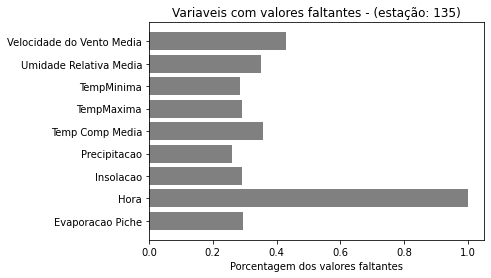

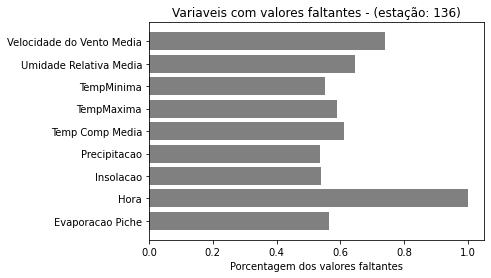

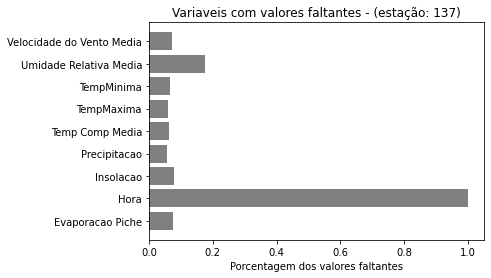

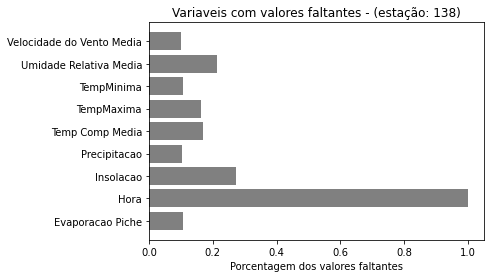

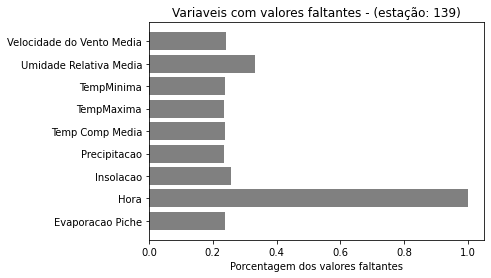

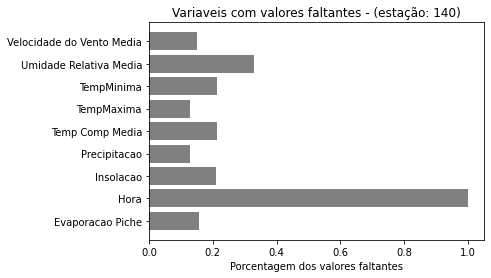

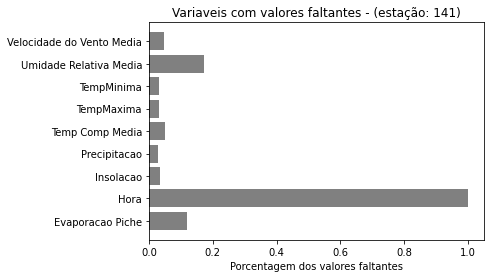

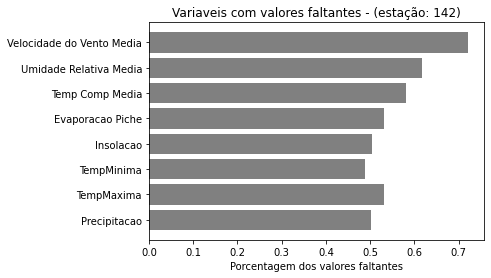

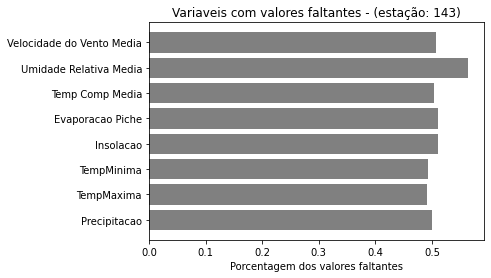

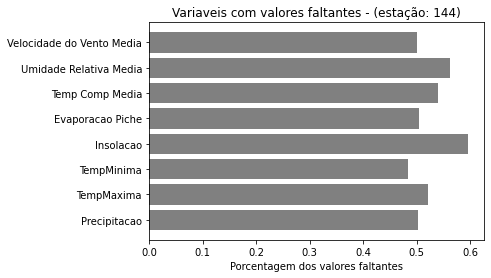

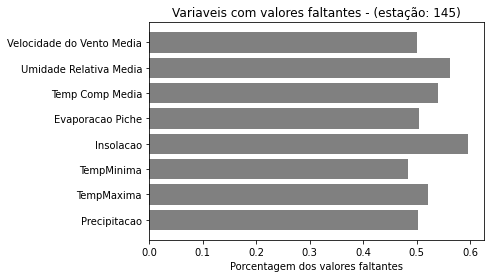

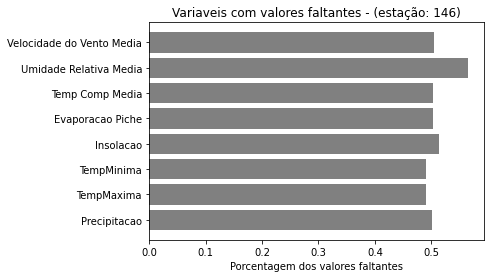

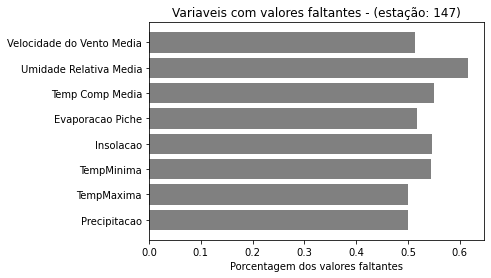

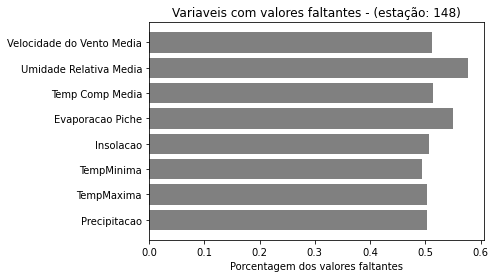

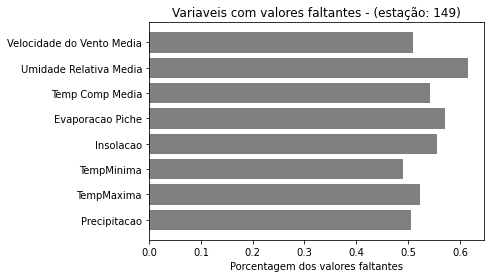

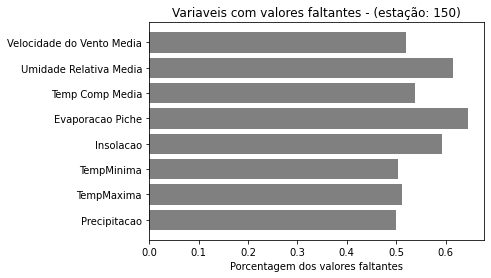

In [27]:
for i in range(1,151):
    df = pd.read_csv('../input/brazilian-weather-stations/station'+ str(i) + '.csv', sep=';', index_col=0)
    
    # Checando quais variaveis estão com valores faltantes

    missing_values = df.columns[df.isnull().any()]
    df[missing_values].isnull().sum()
    
    labels = [] 

    valuecount = [] 

    percentcount = [] 

    for col in missing_values:
        labels.append(col)
        valuecount.append(df[col].isnull().sum())
        # df.shape[0] dará a contagem total de linhas
        percentcount.append(df[col].isnull().sum()/df.shape[0])

    ind = np.arange(len(labels))

    fig, ax1 = plt.subplots()

    rects = ax1.barh(ind, np.array(percentcount), color='gray')
    ax1.set_yticks(ind)
    ax1.set_yticklabels(labels)
    ax1.set_xlabel("Porcentagem dos valores faltantes")
    ax1.set_title("Variaveis com valores faltantes - (estação: " + str(i) + ")")

   Como demonstrado nos gráficos acima, todas as estações possuem um volume considerável de dados faltantes, por esse motivo foi optado por restringir o volume de dados utilizados. 
   Para escolher os dados mais relevantes possíveis primeiro optamos por restringir às estações do estado de Minas Gerais uma vez que é o estado mais relevante na produção de café.

As estações 31,32 e 36 foram escolhidas pois possuiam uma base de dados relevantes devido ao baixo indice de valores faltantes, como pode ser visualizado nos gráficos abaixo.

Text(0.5, 1.0, 'Variaveis com valores faltantes')

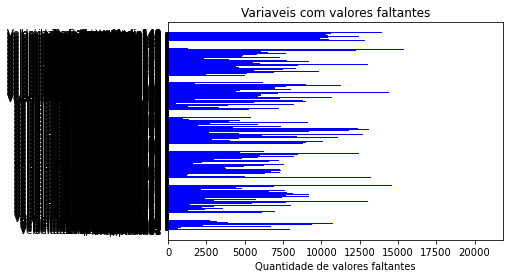

In [28]:
# Checando quais variaveis estão com valores faltantes

#missing_values = df.columns[df.isnull().any()]
#df[missing_values].isnull().sum()
#weather_full_df
missing_values = weather_full_df.columns[weather_full_df.isnull().any()]
weather_full_df[missing_values].isnull().sum()

labels = [] 

valuecount = [] 


percentcount = [] 

for col in missing_values:
    labels.append(col)
    #valuecount.append(df[col].isnull().sum())
    valuecount.append(weather_full_df[col].isnull().sum())
    # df.shape[0] dará a contagem total de linhas
    #percentcount.append(df[col].isnull().sum()/df.shape[0])
    percentcount.append(weather_full_df[col].isnull().sum()/weather_full_df.shape[0])

ind = np.arange(len(labels))

#gráfico - Quantidade de valores faltantes x Variáveis com valores faltantes
fig, ax1 = plt.subplots()

rects = ax1.barh(ind, np.array(valuecount), color='blue')
ax1.set_yticks(ind)
ax1.set_yticklabels(labels)
ax1.set_xlabel("Quantidade de valores faltantes")
ax1.set_title("Variaveis com valores faltantes")

Text(0.5, 1.0, 'Variaveis com valores faltantes')

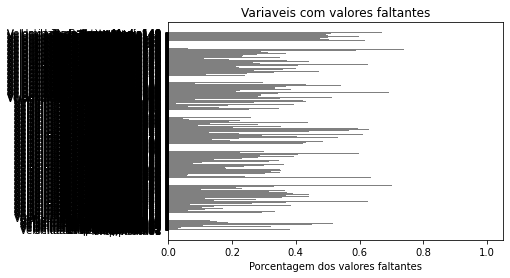

In [29]:
#gráfico - Porcentagem de valores faltantes x Variáveis com valores faltantes
fig, ax2 = plt.subplots()

rects = ax2.barh(ind, np.array(percentcount), color='grey')
ax2.set_yticks(ind)
ax2.set_yticklabels(labels, rotation='horizontal')
ax2.set_xlabel("Porcentagem dos valores faltantes")
ax2.set_title("Variaveis com valores faltantes")

Como demonstrado nos gráficos acima, todas as estações possuem um volume considerável de dados faltantes, por esse motivo, foi decidido que a melhor decisão para tirar conclusões mais sólidas dos resultados das redes neurais seria restringir o volume de dados utilizados. Para escolher os dados mais relevantes possíveis primeiro optamos por restringir às estações do estado de Minas Gerais uma vez que é o estado mais relevante na produção de café. Selecionadas as estações de MG, foi realizada uma análise exploratória manual das estações, com o intuito de escolher estações com poucas lacunas simultaneamente. O resultado dessa busca foi que selecionamos 10 anos de dados, de 01/01/2003 até 01/01/2013 das seguintes estações:

31 - FRUTAL - MG

32 - UBERABA - MG

36 - FLORESTAL - MG


Realizamos as seguintes tratativas para amenizar o nosso problema de dados faltantes que haviam dentro dos datasets:

In [30]:
#Script com o objetido de tratar o preenchimento das lacunas das bases de dados metereológicos
import sys

df_choosen = [31, 32, 36]
start_date = datetime.strptime('01/01/2003', "%d/%m/%Y")
end_date = datetime.strptime('01/01/2013', "%d/%m/%Y")

heading = ['Data', 'Precipitacao', 'TempMaxima', 'TempMinima', 'Insolacao', 'Evaporacao Piche', 'Temp Comp Media', 'Umidade Relativa Media', 'Velocidade do Vento Media']
date = datetime.strptime('20/08/1973', "%d/%m/%Y")
shaped_date = date_shape(date)

for i in df_choosen:#Datasets 31,32,36
    filename = '../input/brazilian-weather-stations/station'+str(i)+'.csv'
    df = pd.read_csv(filename, sep=';')
    mask = (pd.to_datetime(df['Data']) >= start_date) & (pd.to_datetime(df['Data']) <= end_date)
    df = df.loc[mask]
    
    for j in range(len(heading)):
        if j > 0:
            #calculo da media e substituindo os valores nulos
            df[heading[j]].fillna(round(df[heading[j]].rolling(window = 365, min_periods = 3).mean(), 2), inplace=True)
    
    #gerando arquivo de treino
    training_data = 'training_data'+str(i)+'.csv'
    df[heading].to_csv(training_data)

A tratativa do dados foi realizado através do preenchimento utilizando a média dos 3 dias anteriores, na qual pode-se preencher todas as lacunas, podendo ser visualizado conforme os gráficos abaixo.

In [31]:
df_station31a = pd.read_csv('./training_data31.csv', index_col = 0)
df_station32a = pd.read_csv('./training_data32.csv', index_col = 0)
df_station36a = pd.read_csv('./training_data36.csv', index_col = 0)

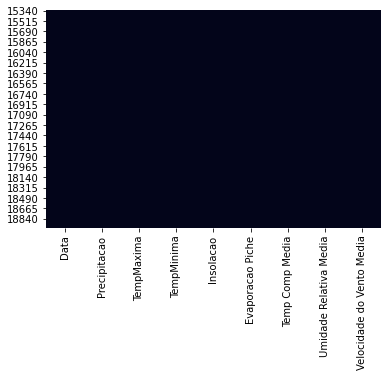

In [32]:
#Verificação de quais partes possuíam lacunas nas estações
sns.heatmap(df_station31a.isnull(), cbar=False)

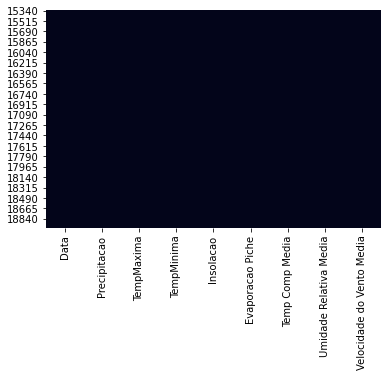

In [33]:
#Verificação de quais partes possuíam lacunas nas estações
sns.heatmap(df_station32a.isnull(), cbar=False)

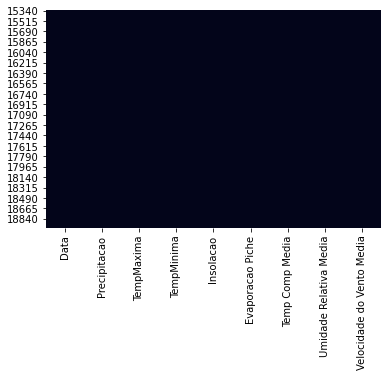

In [34]:
#Verificação de quais partes possuíam lacunas nas estações
sns.heatmap(df_station36a.isnull(), cbar=False)

# Teste de modelos


Durante a fase de experimentos, foram feitas algumas tentativas de como os dados iriam se correlacionar, no entanto partimos do princípio de que há importância no histórico de dados, ou seja, os dados possuem uma ordem de ocorrência e esta é importante para o problema. Por esse motivo todos os modelos testados aqui neste problema utilizaram em algum momento uma LSTM(Long Short Term Memory), nesse contexto foram feitas as seguintes tentativas de redes neurais:
* Classificação utilizando dados de dias de pregões e o tempo
* Regressão utilizando dados de dias de pregões e o tempo
* Regressão utilizando dados com dis de pregões, finais de semana, feriados e o tempo 
* Classificação utilizando dados de semanas de pregões e o tempo 
* Regressão utilizando dados de semanas de pregões e o tempo

Foram utilizadas duas formas de medir o erro dos modelos, para os modelos de classificação, ou seja, para prever se o preço vai subir ou descer, foi utilizada a acurácia, que é o percentual de vezes que o modelo acerta a previsão enquanto os modelos regressores, que tentavam determinar o valor do café utilizavam o erro quadrático médio como referência para ajuste de aprendizado.

In [35]:
#Carregamento dos dados 

full_price = pd.read_csv('../input/coffee-price-noweekend/price_no_weekend.csv')
#full_price = df_price_all_days.drop(['Dia_Semana'], axis=1)

#Selecinando apenas os dados refentes a dia de semana 
#filled_price = df_price_all_days
#filled_price = filled_price.drop(filled_price[filled_price['Dia_Semana'] == 'Saturday'].index)
#filled_price = filled_price.drop(filled_price[filled_price['Dia_Semana'] == 'Sunday'].index)
#filled_price = filled_price.reset_index(drop=True)
#filled_price = filled_price.drop(['Dia_Semana'], axis=1)

filled_price = pd.read_csv('../input/coffeevsweather/price_status.csv')


station31 = pd.read_csv('../input/weather/training_data_beta_31.csv')
station32 = pd.read_csv('../input/weather/training_data_beta_32.csv')
station36 = pd.read_csv('../input/weather/training_data_beta_36.csv')


sc = MinMaxScaler()
oh = OneHotEncoder()

A função create_dataset formatam os dados em matrizes de 3 dimensões, essa saída e necessária para entrada em redes neurais LSTM.

In [36]:
### Criação de dataset para LSTM com dados pareados
def create_lstm_datetime(X, Y, look_back):
    dataX, dataY = [], []
    ncol = len(X.columns)
    
    for i, row in Y.iterrows():
        #a.drop(columns='Data')
        date = row['Data']
        b = row.iloc[1:]
        a = X.loc[ (X['Data'] > date-timedelta(days = look_back)) &  (X['Data'] < date) ].copy()                                                         
        #dataX.append(a.drop(columns='Data').values)
        
        if a.shape == (look_back-1,ncol):
            dataX.append(a.drop(columns='Data').values)
            dataY.append(b)
            

    return np.array(dataX), np.expand_dims(np.array(dataY),-1)

def create_dataset(X, Y, look_back):
    dataX, dataY = [], []
    for i in range(len(Y)-look_back-1):
        a = X[i:(i+look_back)]
        dataX.append(a)

        #b = Y[i+1:(i+look_back+1)]
        b = Y[(i+look_back)][0]
        dataY.append(b)
    #print(dataX)
    return np.array(dataX), np.array(dataY)

def status_def(full_price):
    v0 = 0
    status_lst = []
    previous = 'Alta'
    for i, row in full_price.iterrows():
        sample = row['Valor'] - v0
        if sample>0:
            result = 1
        elif sample == 0:
            result == previous
        else:
            result = 0

        v0 = row['Valor']
        previous = result
        status_lst.append(result)    
    return status_lst

In [37]:
### Output Prep

full_price['Status'] = status_def(full_price)


full_price['Data'] = pd.to_datetime(full_price['Data'],  format='%d/%m/%Y')
heading = ['Precipitacao', 'TempMaxima', 'TempMinima', 'Insolacao', 'Evaporacao Piche', 'Temp Comp Media', 'Umidade Relativa Media', 'Velocidade do Vento Media']

start_date = '01/01/2003'
end_date = '01/01/2013'
price = full_price.loc[ (full_price['Data'] > datetime.strptime(start_date, "%d/%m/%Y")) &  (full_price['Data'] < datetime.strptime(end_date, "%d/%m/%Y")) ]                                                          


### Input Prep
# Weather
df_full = pd.DataFrame([], columns=heading)
for col in heading:
    x = station31[col].values.astype(float)                     ## Mudança de tipo
    df_full[col] = sc.fit_transform(np.expand_dims(x, -1)).T[0] ## Normalização 
    x = station32[col].values.astype(float)
    df_full[col+'2'] = sc.fit_transform(np.expand_dims(x, -1)).T[0]
    x = station36[col].values.astype(float)
    df_full[col+'3'] = sc.fit_transform(np.expand_dims(x, -1)).T[0]

df_full['Data'] = station32['Data']
X_full_W = df_full



In [38]:
df_full.head()

Precipitacao  TempMaxima  TempMinima  Insolacao  Evaporacao Piche  \
0      0.000000    0.554054    0.803571   0.758333          0.123077   
1      0.241058    0.463964    0.808036   0.025000          0.117949   
2      0.133748    0.400901    0.785714   0.108333          0.066667   
3      0.101866    0.409910    0.776786   0.291667          0.071795   
4      0.085537    0.409910    0.776786   0.050000          0.102564   

   Temp Comp Media  Umidade Relativa Media  Velocidade do Vento Media  \
0         0.719192                0.854305                   0.295699   
1         0.675758                0.887417                   0.430108   
2         0.630303                0.894040                   0.252688   
3         0.592929                0.933775                   0.591398   
4         0.621212                0.834437                   0.645161   

   Precipitacao2  Precipitacao3  ...  Insolacao3  Evaporacao Piche2  \
0       0.010653       0.000000  ...    0.343511           0.148148   
1       0.056818       0.443702  ...    0.396947           0.179894   
2       0.183949       0.466603  ...    0.015267           0.142857   
3       0.350852       0.120229  ...    0.183206           0.089947   
4       0.113636       0.048664  ...    0.083969           0.063492   

   Evaporacao Piche3  Temp Comp Media2  Temp Comp Media3  \
0           0.201923          0.655254          0.706107   
1           0.125000          0.648170          0.735369   
2           0.173077          0.591499          0.643766   
3           0.057692          0.544274          0.748092   
4           0.048077          0.513577          0.685751   

   Umidade Relativa Media2  Umidade Relativa Media3  \
0                 0.750000                 0.807407   
1                 0.750000                 0.766667   
2                 0.842466                 0.907407   
3                 0.952055                 0.774074   
4                 0.938356                 0.896296   

   Velocidade do Vento Media2  Velocidade do Vento Media3        Data  
0                    0.310734                    0.171429  01/01/2003  
1                    0.265537                    0.071429  02/01/2003  
2                    0.237288                    0.100000  03/01/2003  
3                    0.480226                    0.071429  04/01/2003  
4                    0.463277                    0.161905  05/01/2003  

[5 rows x 25 columns]

In [39]:
price['Data'] = pd.to_datetime(price['Data'], format='%d/%m/%Y')
X_full_W['Data'] = pd.to_datetime(X_full_W['Data'],format='%d/%m/%Y')

X_lstm, Y_lstm = create_lstm_datetime(X_full_W, price, 14)
np.expand_dims(X_lstm,-1).shape

X_lstm, Y_lstm = create_lstm_datetime(X_full_W, price, 21)
#np.expand_dims(X_lstm,-1).shape
Y_lstm_class = Y_lstm[:, 1].astype('int32') 
#Y_lstm_val = sc.fit_transform(Y_lstm[:, 0])
Y_lstm_val = Y_lstm[:, 0].astype('float64')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Classificação utilizando dados de dias de pregões e o tempo

O primeiro modelo projetado teve como objetivo prever as altas e baixas diárias do preço do café utilizando apenas os dias de pregões e 21 dias acumulados de dados meteorológicos. Nesse modelo e devido ao fato de que não existem como unir os dados passados de preço uma vez que só existem os preços de pregões e portanto somente dias de semana, portanto a rede está fazendo uso de somente os dados meteorológicos dos dias anteriores para tentar prever o comportamento do preço do café

In [40]:
input_shape = X_lstm[1].shape
inputA = Input(shape = input_shape)

#x = LSTM(2, input_shape = input_shape)(inputA) ### Camada de LSTM, 2 memórias
x = LSTM(14, input_shape = input_shape, dropout = 0.3)(inputA) ### Camada de LSTM, 14 memórias
#x = LSTM(21, input_shape = input_shape)(inputA) ### Camada de LSTM, 21 memórias
#x = LSTM(31, input_shape = input_shape)(inputA) ### Camada de LSTM, 31 memórias
#x = LSTM(41, input_shape = input_shape, dropout = 0.1)(inputA) ### Camada de LSTM, 41 memórias
#x = LSTM(41, input_shape = input_shape, dropout = 0.2)(inputA) ### Camada de LSTM, 41 memórias

############## Output setting
### Boolean Up vs Down
x = Dense(5, activation = 'sigmoid')(x)
z = Dense(1, activation = 'sigmoid')(x)        ### Camada densa de classificação
model = Model(inputs=[inputA], outputs=z)
optimizer = K.optimizers.Adam(lr=0.005)
model.compile( loss='binary_crossentropy', optimizer= optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 24)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 14)                2184      
_________________________________________________________________
dense (Dense)                (None, 5)                 75        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 2,265
Trainable params: 2,265
Non-trainable params: 0
_________________________________________________________________


In [41]:
batch_size = 64
max_epochs = 1000

#h = model.fit(x = x_train, y = Y_train, batch_size= batch_size, epochs= max_epochs, verbose=1, validation_split=0.1)
h = model.fit(x = X_lstm, y = Y_lstm_class, batch_size= batch_size, epochs= max_epochs, verbose=1, validation_split=0.3)

Epoch 1/1000
28/28 [==============================] - 1s 31ms/step - loss: 0.7093 - accuracy: 0.5146 - val_loss: 0.6932 - val_accuracy: 0.5007
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6927 - accuracy: 0.5203 - val_loss: 0.6940 - val_accuracy: 0.5007
Epoch 3/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6929 - accuracy: 0.5203 - val_loss: 0.6937 - val_accuracy: 0.5007
Epoch 4/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6923 - accuracy: 0.5186 - val_loss: 0.6938 - val_accuracy: 0.5007
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5203 - val_loss: 0.6942 - val_accuracy: 0.5007
Epoch 6/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6928 - accuracy: 0.5209 - val_loss: 0.6933 - val_accuracy: 0.5007
Epoch 7/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.6926 - accuracy: 0.5100 - val_loss: 0.6934 - val_accuracy: 0.5007

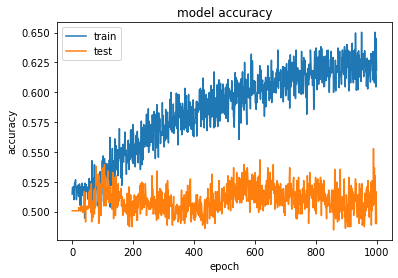

In [42]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

**Resultados**

O problema foi explorado com várias configurações de rede, no entanto as redes sempre acabavam por tender ao overfitting que atingia 100% de acertos no treino mas demonstravam uma taxa de acertos proxima de 50% durante os testes, que nesse caso é a proporção de número de acertos e erros do dataset. 

Depois de alguns testes foi encontrado uma configuração de rede com um LSTM com 14 neurônios e e dropout de 0.3 seguido por uma camada densa com 5 neurônios com ativação sigmóide e uma camada densa de saída que estabilizava o número de acertos por volta de 70% no treino mas os acertos continuavam em 50%. 
    
A rede não demonstra capacidade de identificar o comportamento do preço do café.

## Regressão utilizando dados de dias de pregões e o tempo

In [43]:
input_shape = X_lstm[1].shape
inputA = Input(shape = input_shape)

#x = LSTM(2, input_shape = input_shape)(inputA) ### Camada de LSTM, 2 memórias
#x = LSTM(7, input_shape = input_shape, dropout = 0.3)(inputA) ### Camada de LSTM, 14 memórias
x = LSTM(14, input_shape = input_shape, dropout = 0.3)(inputA)

############## Output setting


### Numeric Value 
z = Dense(1)(x)
model = Model(inputs=[inputA], outputs=z)
model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mae'])
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 24)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 14)                2184      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 15        
Total params: 2,199
Trainable params: 2,199
Non-trainable params: 0
_________________________________________________________________


In [44]:
batch_size = 64
max_epochs = 1000

h = model.fit(x = X_lstm, y = Y_lstm_val, batch_size= batch_size, epochs= max_epochs, verbose=1, validation_split=0.3)

Epoch 1/1000
28/28 [==============================] - 1s 29ms/step - loss: 0.5914 - mse: 0.5914 - mae: 0.6241 - val_loss: 0.8176 - val_mse: 0.8176 - val_mae: 0.7666
Epoch 2/1000
28/28 [==============================] - 0s 13ms/step - loss: 0.0914 - mse: 0.0914 - mae: 0.2392 - val_loss: 1.1393 - val_mse: 1.1393 - val_mae: 0.9553
Epoch 3/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.0758 - mse: 0.0758 - mae: 0.2293 - val_loss: 1.0554 - val_mse: 1.0554 - val_mae: 0.9110
Epoch 4/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.0738 - mse: 0.0738 - mae: 0.2228 - val_loss: 1.0728 - val_mse: 1.0728 - val_mae: 0.9212
Epoch 5/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.0721 - mse: 0.0721 - mae: 0.2223 - val_loss: 1.0751 - val_mse: 1.0751 - val_mae: 0.9229
Epoch 6/1000
28/28 [==============================] - 0s 12ms/step - loss: 0.0711 - mse: 0.0711 - mae: 0.2181 - val_loss: 1.0428 - val_mse: 1.0428 - val_mae: 0.9054
Epoch 7/10

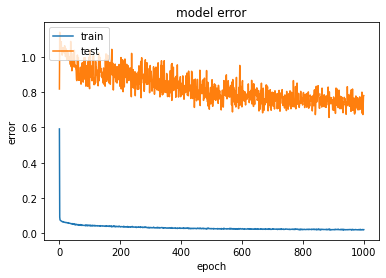

In [45]:
plt.plot(h.history['mse'])
plt.plot(h.history['val_mse'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

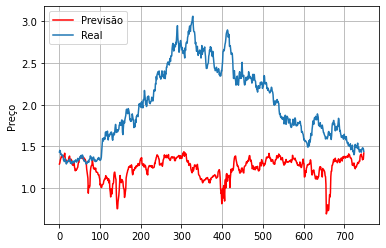

In [46]:
division = int(len(X_lstm) * 0.7)

x_train = X_lstm[0:division]
x_test = X_lstm[division:]

Y_train =  Y_lstm_val[0:division]
Y_test = Y_lstm_val[division:]

np.expand_dims(x_test,-1).shape
predictions = model.predict(x_test)

plt.plot(predictions, "r")
plt.plot(Y_test)
plt.grid(True)
plt.legend(['Previsão', 'Real'], loc='upper left')
plt.ylabel('Preço')
plt.show()

**Resultados**

A rede não foi capaz de definir o valor do café, não importa qual modelo utilizado, todas as vezes a rede demonstrou um erro quadrático médio muito grande e demonstrou um desempenho muito inferior durante os testes.

A única observação foi que a previsão demonstrou um comportamento muito específico e similar ao preço do café em alguns momentos, isso pode sugerir que se existe alguma correlação do preço do café e os dados meteorológicos mas esses dados são apenas uma parte dos fatores que afetam o preço do café, como mostrado no exemplo abaixo.



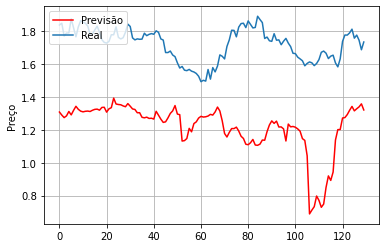

In [47]:
bot, top = 550, 680
plt.plot(predictions[bot:top], "r")
plt.plot(Y_test[bot:top])
plt.grid(True)
plt.legend(['Previsão', 'Real'], loc='upper left')
plt.ylabel('Preço')
plt.show()

O trecho acima foi retirado do gráfico de testes da rede e embora a magnetude esteja incorreta, existe uma paridade nas subidas e descidas. É um sinal positivo mas insuficiente para confirmar que existe uma correlação entre as duas informações.

## Dados Semanais

Depois de tentar criar um modelo capaz de prever as variações diárias do café e não obter um resultado, o problema foi abordado utilizando dados de médias semanais,dado que o comportamento se dá dentro de uma semana, os dados meteorológicos puderam ser utilizados em conjunto com os dados anteriores do preço do café para tentar prever com melhor precisão.

## Classificação utilizando dados de semanas de pregões e o tempo


In [48]:
start_date = '01/01/2002'
end_date = '01/01/2013'
filled_price['Data'] = pd.to_datetime(filled_price['Data'], format='%d/%m/%Y')
price_filled = filled_price.loc[ (filled_price['Data'] > datetime.strptime(start_date, "%d/%m/%Y")) &  (filled_price['Data'] < datetime.strptime(end_date, "%d/%m/%Y")) ]                                                          


In [49]:
price_week = price_filled.set_index('Data').resample('7D').mean().reset_index()
price_week['Status'] = status_def(price_week)
df_week = X_full_W.set_index('Data').resample('7D').mean().reset_index()
X_week = df_week.drop(columns='Data').to_numpy()
df_week['Valor'] = price_week['Valor']
X_week_valor = df_week.drop(columns='Data').to_numpy()

In [50]:
Y = oh.fit_transform(np.expand_dims(price_filled['Status'], -1)).toarray()### Boolean up or down

df_day_filled = X_full_W
df_day_filled['Valor'] = price_filled['Valor']
X = df_day_filled.drop(columns='Data').to_numpy()
X_lstm_fill_class, Y_lstm_fill_class = create_dataset(X, np.expand_dims(Y[:, 0], -1), 21)

Y_lstm_fill_class.shape

(3631,)

In [51]:
input_shape = X_lstm_fill_class[1].shape
inputA = Input(shape = input_shape)

#x = LSTM(7, input_shape = input_shape)(inputA) ### Camada de LSTM, 7 memórias
x = LSTM(14, input_shape = input_shape, dropout = 0.5)(inputA) ### Camada de LSTM, 7 memórias
#x = LSTM(21, input_shape = input_shape)(inputA) ### Camada de LSTM, 21 memórias
#x = LSTM(31, input_shape = input_shape)(inputA) ### Camada de LSTM, 31 memórias
#x = LSTM(41, input_shape = input_shape)(inputA) ### Camada de LSTM, 41 memórias
#x = LSTM(41, input_shape = input_shape, dropout = 0.2)(inputA) ### Camada de LSTM, 41 memórias

############## Output setting
### Boolean Up vs Down
x = Dense(5, activation = 'sigmoid')(x)
z = Dense(1, activation = 'sigmoid')(x)        ### Camada densa de classificação
model = Model(inputs=[inputA], outputs=z)
optimizer = K.optimizers.Adam(lr=0.005)
model.compile( loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 21, 25)]          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 14)                2240      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 2,321
Trainable params: 2,321
Non-trainable params: 0
_________________________________________________________________


In [52]:
batch_size = 64
max_epochs = 1000

h = model.fit(x = X_lstm_fill_class, y = Y_lstm_fill_class, batch_size= batch_size, epochs= max_epochs, verbose=1, validation_split=0.3)


Epoch 1/1000
40/40 [==============================] - 1s 26ms/step - loss: 0.7509 - accuracy: 0.4978 - val_loss: 0.6933 - val_accuracy: 0.4963
Epoch 2/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6936 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 3/1000
40/40 [==============================] - 1s 16ms/step - loss: 0.6934 - accuracy: 0.4978 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 4/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6934 - accuracy: 0.4845 - val_loss: 0.6934 - val_accuracy: 0.4963
Epoch 5/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.4967 - val_loss: 0.6931 - val_accuracy: 0.5055
Epoch 6/1000
40/40 [==============================] - 1s 15ms/step - loss: 0.6932 - accuracy: 0.4955 - val_loss: 0.6931 - val_accuracy: 0.5037
Epoch 7/1000
40/40 [==============================] - 1s 14ms/step - loss: 0.6934 - accuracy: 0.5018 - val_loss: 0.6935 - val_accuracy: 0.4963

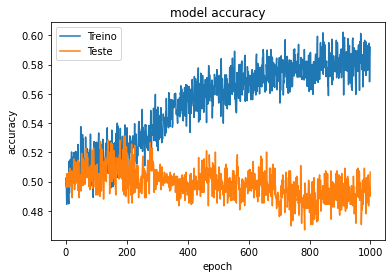

In [53]:
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Treino', 'Teste'], loc='upper left')

In [54]:
division = int(len(X_lstm_fill_class) * 0.7)

x_train = X_lstm_fill_class[0:division]
x_test = X_lstm_fill_class[division:]

Y_train =  Y_lstm_fill_class[0:division]
Y_test = Y_lstm_fill_class[division:]

In [55]:
eval_test1 = model.evaluate(x_test, Y_test, verbose=0)
print("Erro médio do teste: Perda {0:.4f}, Acc. {1:.4f}".format(eval_test1[0], eval_test1[1]))


Erro médio do teste: Perda 0.7076, Acc. 0.5064


**Resultados**

O comportamentoda rede foi similar ao obtido quando a rede tentava prever as altas e baixas dos dias, reforçando as conclusões sobre a relação do tempo e o café.

## Regressão utilizando dados de semanas de pregões e o tempo

In [56]:
Y =  np.expand_dims(price_week["Valor"].to_numpy(), -1)

X_lstm_fill_reg_week, Y_lstm_fill_reg_week = create_dataset(X_week_valor,Y, 8)
Y_lstm_fill_reg_week = np.expand_dims(Y_lstm_fill_reg_week, -1)

In [57]:

inputA = Input(shape = input_shape)

x = LSTM(14, input_shape = input_shape)(inputA) ### Camada de LSTM, 14 memórias 
z = Dense(1)(x)

model = Model(inputs=[inputA], outputs=z)
model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae'])
model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 21, 25)]          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 14)                2240      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 15        
Total params: 2,255
Trainable params: 2,255
Non-trainable params: 0
_________________________________________________________________


In [58]:
batch_size = 64
max_epochs = 500

h = model.fit(x = X_lstm_fill_reg_week, y = Y_lstm_fill_reg_week, batch_size= batch_size, epochs= max_epochs, verbose=1, validation_split=0.3)


Epoch 1/500
6/6 [==============================] - 1s 128ms/step - loss: 1.2601 - mse: 1.6521 - mae: 1.2601 - val_loss: 1.9349 - val_mse: 3.9501 - val_mae: 1.9349
Epoch 2/500
6/6 [==============================] - 0s 11ms/step - loss: 0.9521 - mse: 0.9704 - mae: 0.9521 - val_loss: 1.6482 - val_mse: 2.9318 - val_mae: 1.6482
Epoch 3/500
6/6 [==============================] - 0s 9ms/step - loss: 0.6616 - mse: 0.5038 - mae: 0.6616 - val_loss: 1.3796 - val_mse: 2.1280 - val_mae: 1.3796
Epoch 4/500
6/6 [==============================] - 0s 9ms/step - loss: 0.4029 - mse: 0.2117 - mae: 0.4029 - val_loss: 1.1295 - val_mse: 1.5076 - val_mae: 1.1295
Epoch 5/500
6/6 [==============================] - 0s 10ms/step - loss: 0.2432 - mse: 0.0810 - mae: 0.2432 - val_loss: 0.9151 - val_mse: 1.0724 - val_mae: 0.9151
Epoch 6/500
6/6 [==============================] - 0s 10ms/step - loss: 0.1936 - mse: 0.0621 - mae: 0.1936 - val_loss: 0.7711 - val_mse: 0.8293 - val_mae: 0.7711
Epoch 7/500
6/6 [============

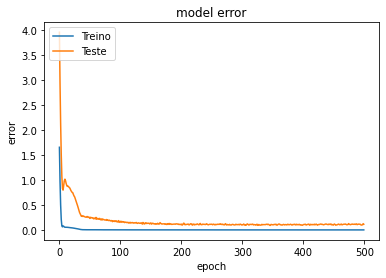

In [59]:
plt.plot(h.history['mse'])
plt.plot(h.history['val_mse'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['Treino', 'Teste'], loc='upper left')

In [60]:
division = int(len(X_lstm_fill_reg_week) * 0.7)

x_train = X_lstm_fill_reg_week[0:division]
x_test = X_lstm_fill_reg_week[division:]

Y_train =  Y_lstm_fill_reg_week[0:division]
Y_test = Y_lstm_fill_reg_week[division:]

predictions = model.predict(x_test)

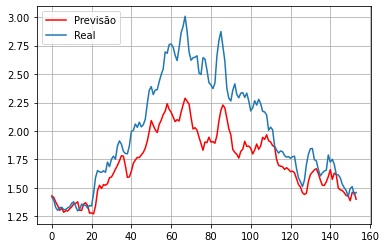

In [61]:
plt.plot(predictions, "r")
plt.plot(Y_test)
plt.grid(True)
plt.legend(['Previsão', 'Real'], loc='upper left')
plt.show()

**Resultados**

A rede mostrou muito mais capacidade de representar o comportamento da rede, no entanto depois de observações mais detalhadas, a tendência da rede não apresentava a capacidade de prever a rede mas de seguir o preço, dado que o comportamento seguia os os resultados anteriores da do preço do café como resposta e portanto não permite a conclusão de que a rede neural esteja de fato antecipando o preço do café.

# Conclusão

Dada as circunstâncias em que os dados se encontravam, não foi possível definir uma rede capaz de prever o comportamento do preço do café com os dados meteorológicos disponíveis, seja classificando por altas e baixas ou tentando prever o preço do café, nenhuma rede demonstrou um comportamento que mostrasse um resultado inequívoco de sua eficácia. No entanto, existem curtos periodos onde a similaridade da curva de previsão com a de preço sugerem que pode existir alguma relação entre os dois, mas essa relação por sua vez é insuficiente para precificar em todas as situações, o que abre espaço para mais trabalhos futuros utilizando dados de outras naturezas adicionados aos dados meteorológicos para tentar precificar o café.

